# Outline

Goal: Understand the connection between natural disasters and popular opinion, especially towards the government and other aid providers

Method: Analyze public opinion before and after natural disasters, including areas severely and moderately affected

Model: ... Train model on ???

Resources: Twitter Data via Tweepy and/or Selenium

Miscellania: Aspected-Based Sentiment Analysis, Comparison with polling, Comparison with expert analysis of 'The Street'

### Database:
1. Survey commonly used words around earthquakes, esp. re: government - identify key words, aspect words
1.  Scrape tweets before/after particular earthquake
1.  Label tweets (trick Moroccon high schoolers into labelling them)

## Timeline

1. Acquire data
  1. X Research which earthquakes to focus on (english-speaking countries? and then Arabic for middle east) (12.17)
      * Anchorage
  2. X Survey tweets to identify key words and aspect words. (12.18)
      * 'Alaskaquake' 'Anxiety' 'Resilient' 'AKEarthquake' 'AKquake''AlaskaEarthquake' 'FEMA' 'Trump' 'Dems'
  3. X Query using those words to get actual data. (12.18)
      * 'AKQuake' 'AlaskaEarthquake'
  4. X Write report (12.19 - airplane)
      * https://medium.com/@chylirk/disaster-project-report-1-1708b838bbf1
2. Exploratory data analysis (EDA) with tweet data.
  * X unsupervised, before labelling (12.20)
      * USGS, Alaska Earthquake Center, BP Foundation, American Red Cross of Alaska, ExxonMobil, Alyeska Pipeline,  Salvation Army, United Way of Anchorage, The Foraker Group, Trump, Palin, Murkowski, Walker, DOT, Jeep, BP, President
  * X word clouds based on period, region, etc. (12.20)
  * X Write report (12.21)
3. Label (womp womp)
  * X Come up with labelling standards. (12.19 - airplane)
      * -1, 0, 1
      * Topics: Trump, Governor Dunleavy, Senators Murkowski/Sullivan, 
  * X How fine is the scale? What are we measuring? (e.g. Approval of Government 0-5, approval of yakuza +/-) (12.19)
  * X Label ~2000 data based on aspect, sentiment (12.22)
  * Cluster remaining data based on labelled data (12.25)
  * Hand-label ambiguous data points (12.27)
  * Write Report (12.28)
4. Second EDA, with the labelled data
  * Correlations/relationships based on location, age, etc. (12.29)
  * Do more research on what ppl do to analyze labeled text (12.20)
  * X Clean up data: remove special chars, etc. (12.30)
  * Write Report (12.31)
5. Model
  * Traditional approaches
    * X TF-IDF + Naive Bayes (1.01)
    * TF-IDF + XGBoost/CatBoost/LightGBM (more sophisticated, but not deep learning algorithm) (1.04)
    * Write Report (1.08)
  * Deep learning
    * Look for FastText or other pre-trained word embeddings (1.01)
    * Study RNNs (12.18)
    * Study Keras (Tensorflow is too complicated) (12.20)
    * Build a simple layered LSTM/GRU model, maybe do bi-directional etc. maybe add attention. (1.10)
    * Write Report (1.15)
6. Model comparison (1.16)
7. Interpret results (interpret model), if possible (1.18)
 * Write Report (1.20)

# Import

In [111]:
import re
from time import time

In [112]:
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [113]:
import xgboost as xgb

In [114]:
from tqdm import tqdm
from sklearn.svm import SVC

In [115]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

ModuleNotFoundError: No module named 'keras'

In [116]:
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [117]:
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [118]:
import tweepy
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy.streaming import StreamListener
from textblob import TextBlob

In [119]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.text import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
 
from bs4 import BeautifulSoup as bs
import time

In [120]:
from pprint import pprint

# Mining Data

## Selenium 

In [119]:
username = 'chylirk@gmail.com'
password = 'DisasterProject'

In [120]:
def init_driver():
 
     # initiate the driver:
     driver = webdriver.Firefox(executable_path=r'../Disaster_Project/geckodriver.exe')
 
     # set a default wait time for the browser [5 seconds here]:
     driver.wait = WebDriverWait(driver, 5)
 
     return driver

In [121]:
def close_driver(driver):
 
    driver.close()
 
    return

In [122]:
def login_twitter(driver, username, password):
 
    # open the web page in the browser:
    driver.get("https://twitter.com/login")
 
    # find the boxes for username and password
    username_field = driver.find_element_by_class_name("js-username-field")
    password_field = driver.find_element_by_class_name("js-password-field")
 
    # enter your username:
    username_field.send_keys(username)
    driver.implicitly_wait(1)
 
    # enter your password:
    password_field.send_keys(password)
    driver.implicitly_wait(1)
 
    # click the "Log In" button:
    driver.find_element_by_class_name("EdgeButtom--medium").click()
 
    return

In [123]:
class wait_for_more_than_n_elements_to_be_present(object):
    def __init__(self, locator, count):
        self.locator = locator
        self.count = count
 
    def __call__(self, driver):
        try:
            elements = EC._find_elements(driver, self.locator)
            return len(elements) > self.count
        except StaleElementReferenceException:
            return False

In [124]:
def search_twitter(driver, query):
 
    # wait until the search box has loaded:
    box = driver.wait.until(EC.presence_of_element_located((By.NAME, "q")))
 
    # find the search box in the html:
    driver.find_element_by_name("q").clear()
 
    # enter your search string in the search box:
    box.send_keys(query)
 
    # submit the query (like hitting return):
    box.submit()
 
    # initial wait for the search results to load
    wait = WebDriverWait(driver, 10)
 
    try:
        # wait until the first search result is found. Search results will be tweets, which are html list items and have the class='data-item-id':
        wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR, "li[data-item-id]")))
 
        # scroll down to the last tweet until there are no more tweets:
        while True:
 
            # extract all the tweets:
            tweets = driver.find_elements_by_css_selector("li[data-item-id]")
 
            # find number of visible tweets:
            number_of_tweets = len(tweets)
 
            # keep scrolling:
            driver.execute_script("arguments[0].scrollIntoView();", tweets[-1])
 
            try:
                # wait for more tweets to be visible:
                wait.until(wait_for_more_than_n_elements_to_be_present(
                    (By.CSS_SELECTOR, "li[data-item-id]"), number_of_tweets))
 
            except TimeoutException:
                # if no more are visible the "wait.until" call will timeout. Catch the exception and exit the while loop:
                break
 
        # extract the html for the whole lot:
        page_source = driver.page_source
 
    except TimeoutException:
 
        # if there are no search results then the "wait.until" call in the first "try" statement will never happen and it will time out. So we catch that exception and return no html.
        page_source=None
 
    return page_source

In [125]:
def extract_tweets(page_source):
 
    soup = bs(page_source,'lxml')
 
    tweets = []
    for li in soup.find_all("li", class_='js-stream-item'):
 
        # If our li doesn't have a tweet-id, we skip it as it's not going to be a tweet.
        if 'data-item-id' not in li.attrs:
            continue
 
        else:
            tweet = {
                'tweet_id': li['data-item-id'],
                'text': None,
                'user_id': None,
                'user_screen_name': None,
                'user_name': None,
                'created_at': None,
                'retweets': 0,
                'likes': 0,
                'replies': 0
            }
 
            # Tweet Text
            text_p = li.find("p", class_="tweet-text")
            if text_p is not None:
                tweet['text'] = text_p.get_text()
 
            # Tweet User ID, User Screen Name, User Name
            user_details_div = li.find("div", class_="tweet")
            if user_details_div is not None:
                tweet['user_id'] = user_details_div['data-user-id']
                tweet['user_screen_name'] = user_details_div['data-screen-name']
                tweet['user_name'] = user_details_div['data-name']
 
            # Tweet date
            date_span = li.find("span", class_="_timestamp")
            if date_span is not None:
                tweet['created_at'] = float(date_span['data-time-ms'])
 
            # Tweet Retweets
            retweet_span = li.select("span.ProfileTweet-action--retweet > span.ProfileTweet-actionCount")
            if retweet_span is not None and len(retweet_span) > 0:
                tweet['retweets'] = int(retweet_span[0]['data-tweet-stat-count'])
 
            # Tweet Likes
            like_span = li.select("span.ProfileTweet-action--favorite > span.ProfileTweet-actionCount")
            if like_span is not None and len(like_span) > 0:
                tweet['likes'] = int(like_span[0]['data-tweet-stat-count'])
 
            # Tweet Replies
            reply_span = li.select("span.ProfileTweet-action--reply > span.ProfileTweet-actionCount")
            if reply_span is not None and len(reply_span) > 0:
                tweet['replies'] = int(reply_span[0]['data-tweet-stat-count'])
 
            tweets.append(tweet)
 
    return tweets

### Example - Kashoggi

In [33]:
if __name__ == "__main__":
 
    # start a driver for a web browser:
    driver = init_driver()
 
    # log in to twitter (replace username/password with your own):
    username = 'chylirk@gmail.com'
    password = 'DisasterProject'
    login_twitter(driver, username, password)
 
    # search twitter:
    query = "خاشقجي"
    page_source = search_twitter(driver, query)
 
    # extract info from the search results:
    Ktweets = extract_tweets(page_source)
     
    # ==============================================
    # add in any other functions here
    # maybe some analysis functions
    # maybe a function to write the info to file
    # ==============================================
 
    # close the driver:
    close_driver(driver)

NameError: name 'StaleElementReferenceException' is not defined

In [22]:
Ktweets

[{'tweet_id': '1078002316568072194',
  'text': 'Now trending in #SaudiArabia "Khashoggi and his relationship to the Muslim brotherhood" #خاشقجي_وعلاقته_بالإخوان1',
  'user_id': '753305501685862400',
  'user_screen_name': 'Kingslayer745',
  'user_name': 'Mustafa A. A.',
  'created_at': 1545850755000.0,
  'retweets': 0,
  'likes': 0,
  'replies': 1},
 {'tweet_id': '1077593598483402754',
  'text': 'No words needed! \n#WashingtonPost\n#قطر_تكتب_مقالات_خاشقجي pic.twitter.com/6Hui8S3RzP',
  'user_id': '626858605',
  'user_screen_name': 'AlsalimSaeed',
  'user_name': 'سعيد | Saeed',
  'created_at': 1545753309000.0,
  'retweets': 0,
  'likes': 0,
  'replies': 0},
 {'tweet_id': '1078057227288825857',
  'text': "His murderers are still at large the West love dictators muderers coup generals who massacre their people and provide them with arms &sophisticated weapons as long as they destroy their people's freedom and their countries  #JamalKhashoggi #JusticeforJamal #جمال_خاشقجي pic.twitter.com/sf

In [20]:
KJtweets = pd.DataFrame(Ktweets).copy()

In [21]:
len(KJtweets)

20

In [148]:
Ktweets[(Ktweets.likes > 100) & (Ktweets.replies > 11)]

created_at  likes  replies  retweets  \
15  1.542319e+12    139       12        37   
16  1.542303e+12    917       50       109   

                                                 text             tweet_id  \
15  #آمریکا استرداد #فتح‌الله_گولن به #ترکیه را به...  1063189696208097280   
16  شبکه خبری «ان‌بی‌سی»: اطرافیان #ترامپ در کاخ‌س...  1063120682698108928   

      user_id       user_name user_screen_name  
15  817403221  euronews فارسی      euronews_pe  
16  920317916     بهمن كلباسى       bbckalbasi

### Alaska 

In [46]:
if __name__ == "__main__":
 
    # start a driver for a web browser:
    driver = init_driver()
 
    # log in to twitter (replace username/password with your own):
    username = 'chylirk@gmail.com'
    password = 'DisasterProject'
    login_twitter(driver, username, password)
 
    # search twitter:
    query = "AKEarthquake"
    page_source = search_twitter(driver, query)
 
    # extract info from the search results:
    AKEarthquake = extract_tweets(page_source)
     
    # ==============================================
    # add in any other functions here
    # maybe some analysis functions
    # maybe a function to write the info to file
    # ==============================================
 
    # close the driver:
    close_driver(driver)

In [47]:
AKEarthquake

[{'tweet_id': '1069070971175227392',
  'text': '.@APDInfo, @mayorethananc, @AWWU_Info, @afdinfo, @ASD_Info, @AlaskaDOTPF, & @AkGovBillWalker: Thanks for keeping us informed. Extremely appreciated. #AkEarthquake',
  'user_id': '58399764',
  'user_screen_name': 'lelakis',
  'user_name': 'amory lelake',
  'created_at': 1543721356000.0,
  'retweets': 4,
  'likes': 19,
  'replies': 0},
 {'tweet_id': '1068764237051219969',
  'text': 'Alright aftershocks. You’ve got my attention. \n\nNot.  A.  Fan. \n#akearthquake #AlaskaEarthquake',
  'user_id': '6747632',
  'user_screen_name': 'jdhemsath',
  'user_name': 'Josh Hemsath',
  'created_at': 1543648225000.0,
  'retweets': 0,
  'likes': 11,
  'replies': 0},
 {'tweet_id': '1068775153725693952',
  'text': 'With all the earthquake and aftershocks today, after cleanup I should have been knitting like a motherfucker, but I haven’t been able to settle down enough. #AkEarthquake',
  'user_id': '3249495786',
  'user_screen_name': 'stacy_koster',
  'user_n

In [32]:
AKQuake = pd.DataFrame(tweets).copy()

In [37]:
AKQuake.to_csv('AKQuake.csv')

In [42]:
Alaska_Earthquake = pd.DataFrame(AlaskaEarthquake).copy()

In [43]:
Alaska_Earthquake.to_csv('Alaska_Earthquake.csv')

In [49]:
AKEarthquake = pd.DataFrame(AKEarthquake).copy()

In [50]:
AKEarthquake.to_csv('AKEarthquake.csv')

In [62]:
AKQuake = pd.read_csv(f'AKQuake.csv', low_memory=False)

In [63]:
Alaska_Earthquake = pd.read_csv(f'Alaska_Earthquake.csv', low_memory=False)

In [64]:
AKEarthquake = pd.read_csv(f'AKEarthquake.csv', low_memory=False)

## Tweepy

In [143]:
consumer_key = 'w9ZAiaxXRLv8hK5Ogf3T359ni'
consumer_secret = 'l6MREVo4VRSqiohUiCQtuXB5yVLpKsx26psqoOfuMRNH8r2drf'
access_token =a '1074584667997622272-Aur1m9nU45NYjRhTahzQUqITr5KIkU'
access_secret = 'iVSUXtHebYhEhE0TJwXEAHYNC2pj2kYKz2CifwYbtc6he'
 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth)

In [ ]:
for friend in tweepy.Cursor(api.friends).items():
    print(friend._json['name'])

# Exploring Data

In [16]:
AKQuake = pd.read_csv(f'AKQuake.csv', low_memory=False)

Alaska_Earthquake = pd.read_csv(f'Alaska_Earthquake.csv', low_memory=False)

AKEarthquake = pd.read_csv(f'AKEarthquake.csv', low_memory=False)

### Plotting

In [52]:
len(AKEarthquake)

20

In [96]:
AKQuake.describe()

created_at       likes     replies    retweets
count  1.000000e+02  100.000000  100.000000  100.000000
mean   1.476222e+12   16.520000    1.450000   12.790000
std    3.737350e+10   28.820405    2.928008   26.470603
min    1.453632e+12    0.000000    0.000000    0.000000
25%    1.453637e+12    5.000000    0.000000    3.000000
50%    1.453669e+12    8.000000    1.000000    5.000000
75%    1.496111e+12   14.000000    2.000000   10.000000
max    1.544562e+12  208.000000   23.000000  207.000000

In [62]:
AKEarthquake.describe()

created_at       likes    replies   retweets
count  2.000000e+01   20.000000  20.000000  20.000000
mean   1.543885e+12   30.700000   2.750000  11.900000
std    4.525154e+08   37.042081   4.598341  23.507893
min    1.543623e+12    2.000000   0.000000   0.000000
25%    1.543647e+12   10.000000   0.000000   0.750000
50%    1.543670e+12   14.500000   1.000000   1.000000
75%    1.543870e+12   27.750000   3.000000   7.500000
max    1.545157e+12  130.000000  19.000000  95.000000

In [59]:
Alaska_Earthquake.describe()

created_at         likes      replies      retweets
count  1.552000e+03   1552.000000  1552.000000   1552.000000
mean   1.514103e+12    242.469072    13.493557    138.994845
std    3.368731e+10   2240.461312   104.141784    841.635350
min    1.443189e+12      0.000000     0.000000      0.000000
25%    1.494386e+12      8.000000     0.000000      6.750000
50%    1.516765e+12     35.000000     1.000000     25.500000
75%    1.543619e+12    115.000000     7.000000     78.250000
max    1.545405e+12  72348.000000  2681.000000  27715.000000

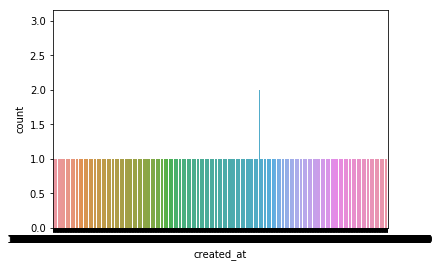

In [63]:
sns.countplot(data=Alaska_Earthquake, x='created_at')

In [84]:
Alaska_Earthquake_mod = Alaska_Earthquake.copy()

In [86]:
Alaska_Earthquake_mod.likes = Alaska_Earthquake_mod.likes + 1

In [90]:
np.log(Alaska_Earthquake_mod.likes[0])

0.0

In [91]:
Alaska_Earthquake_mod.likes = np.log(Alaska_Earthquake_mod.likes)

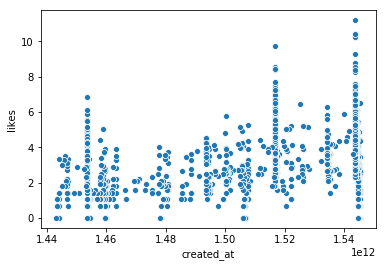

In [94]:
sns.scatterplot(data=Alaska_Earthquake_mod,x='created_at',y='likes')

In [97]:
AKQuake_mod = AKQuake.copy()

AKQuake_mod.likes = AKQuake_mod.likes + 1

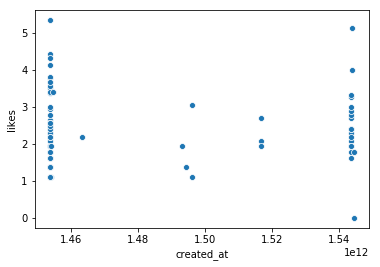

In [98]:
AKQuake_mod.likes = np.log(AKQuake_mod.likes)

sns.scatterplot(data=AKQuake_mod,x='created_at',y='likes')

In [99]:
AKEarthquake_mod = AKEarthquake.copy()

AKEarthquake_mod.likes = AKEarthquake_mod.likes + 1

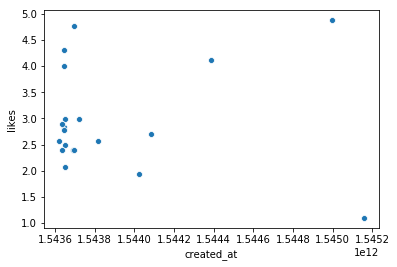

In [100]:
AKEarthquake_mod.likes = np.log(AKEarthquake_mod.likes)

sns.scatterplot(data=AKEarthquake_mod,x='created_at',y='likes')

In [109]:
Alaska_Earthquake

created_at  likes  replies  retweets  \
0     1.545405e+12      0        0         1   
1     1.544998e+12    130        6        95   
2     1.545239e+12      0        0         0   
3     1.545374e+12      0        0         0   
4     1.545341e+12      0        0         0   
5     1.545099e+12     32        0        21   
6     1.545341e+12      0        0         0   
7     1.545328e+12     31        7        40   
8     1.545330e+12      1        0         0   
9     1.545337e+12      1        0         0   
10    1.545328e+12      0        0         0   
11    1.545265e+12      0        0         0   
12    1.545332e+12      0        0         0   
13    1.545374e+12      3        0         0   
14    1.545286e+12      0        0         0   
15    1.545382e+12      1        0         3   
16    1.545381e+12      3        0         1   
17    1.545381e+12      3        0         2   
18    1.545328e+12      0        0         0   
19    1.545328e+12      0        0         0   
20    1.545392e+12      1        0         1   
21    1.545351e+12      4        0         0   
22    1.545315e+12      0        0         0   
23    1.545283e+12     83        3        63   
24    1.545255e+12     13        0        10   
25    1.545185e+12    671        6       162   
26    1.545127e+12      0        0         0   
27    1.545101e+12      0        0         0   
28    1.545080e+12      0        0         0   
29    1.545066e+12      0        0         0   
...            ...    ...      ...       ...   
1522  1.446983e+12     19        0        59   
1523  1.446983e+12      3        0         5   
1524  1.446980e+12     14        0        46   
1525  1.446854e+12      2        0         6   
1526  1.446820e+12     18        1        13   
1527  1.446820e+12      5        2         2   
1528  1.446820e+12      6        0         1   
1529  1.446773e+12     21        0        40   
1530  1.446393e+12      7        1        27   
1531  1.446138e+12     32       14        50   
1532  1.446088e+12      5        0         7   
1533  1.445757e+12     25        0        21   
1534  1.445280e+12      5        0        12   
1535  1.445208e+12     19        2         1   
1536  1.444075e+12      2        0         4   
1537  1.444074e+12      3        0         8   
1538  1.444071e+12      1        0         4   
1539  1.444070e+12      0        0         2   
1540  1.444070e+12      2        0         2   
1541  1.444069e+12      0        0         1   
1542  1.444068e+12      1        0         3   
1543  1.444067e+12      3        0         8   
1544  1.444067e+12     27        1        45   
1545  1.444055e+12      0        0         1   
1546  1.444032e+12      0        0         1   
1547  1.444032e+12      0        0         1   
1548  1.443653e+12      2        0         6   
1549  1.443578e+12      2        0         2   
1550  1.443425e+12      1        0         0   
1551  1.443189e+12      0        0         1   

                                                   text             tweet_id  \
0     2.0 magnitude #earthquake. 112km SW of Anchor ...  1076132704599633921   
1     Here's a milestone. 2018 marks the first time ...  1074426144764583937   
2     Amidst last month's earthquake, this #prolife ...  1075435088475811841   
3     3.0 magnitude #earthquake. 84km SSW of Shishma...  1076003097460260864   
4     Who caused that earthquake in Russia, did USA ...  1075864682773340162   
5     As you prepare for the holidays, it's also a g...  1074849090872246273   
6     #Earthquake  M 2.6 - 16km SSW of Big Lake, Ala...  1075865186974736384   
7     MORE: There is no threat as of yet to #Alaska,...  1075810136306999299   
8     #Earthquake (#sismo) M3.3 strikes 31 km E of #...  1075817724180398080   
9     @DeborahNorville Prayers for the people in and...  1075848317282803713   
10    Earthquake:  mb 3.9 UNIMAK ISLAND REGION, ALAS...  1075807826851770368   
11    Please ShareTop 10 Time to Get Vocal! Video sh...  10755441810897

In [110]:
text = Alaska_Earthquake['text']

In [111]:
text

0       2.0 magnitude #earthquake. 112km SW of Anchor ...
1       Here's a milestone. 2018 marks the first time ...
2       Amidst last month's earthquake, this #prolife ...
3       3.0 magnitude #earthquake. 84km SSW of Shishma...
4       Who caused that earthquake in Russia, did USA ...
5       As you prepare for the holidays, it's also a g...
6       #Earthquake  M 2.6 - 16km SSW of Big Lake, Ala...
7       MORE: There is no threat as of yet to #Alaska,...
8       #Earthquake (#sismo) M3.3 strikes 31 km E of #...
9       @DeborahNorville Prayers for the people in and...
10      Earthquake:  mb 3.9 UNIMAK ISLAND REGION, ALAS...
11      Please ShareTop 10 Time to Get Vocal! Video sh...
12      Magnitude 3.3 Minor Earthquake Hits 30km ESE o...
13      #Earthquake (#sismo) M3.0 strikes 22 km NW of ...
14      #Earthquake  M 2.9 - 16km NW of Anchorage, Ala...
15      The December 20, 2018 M7.3 earthquake east of ...
16      1.8 magnitude #earthquake. 48km SW of Cantwell...
17      How we

### WordClouds

In [113]:
wordcloud = WordCloud().generate(text[0])

In [114]:
wordcloud

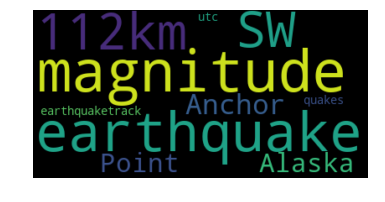

In [115]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [116]:
text2 = " ".join(tweet for tweet in text)

In [117]:
text2

'2.0 magnitude #earthquake. 112km SW of Anchor Point, Alaska http://www.earthquaketrack.com/quakes/2018-12-21-15-01-36-utc-2-0-73\xa0… Here\'s a milestone. 2018 marks the first time we have ever recorded 50,000 earthquakes in Alaska. There\'s an earthquake counter at the bottom of our home page, http://earthquake.alaska.edu\xa0, if you want to follow along.pic.twitter.com/chA4Rvq8iE Amidst last month\'s earthquake, this #prolife pregnancy center provided diapers and other emergency needs to #Alaska families. | After the Earthquake: Alaska Pregnancy Center Spared from Destruction http://bit.ly/2Ev3J4t\xa0 via @PHC_Newspic.twitter.com/Autne7T8k3 3.0 magnitude #earthquake. 84km SSW of Shishmaref, Alaska http://www.earthquaketrack.com/quakes/2018-12-21-06-16-51-utc-3-0-4\xa0… Who caused that earthquake in Russia, did USA ???? As they did in Alaska a few weeks ago  As you prepare for the holidays, it\'s also a good time to be sure you\'re prepared for the next earthquake. Follow along this 

In [118]:
wordcloud_all = WordCloud().generate(text2)

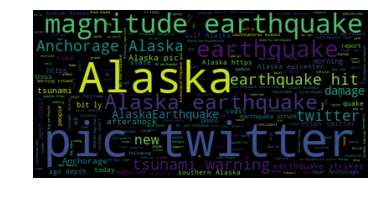

In [119]:
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis("off")
plt.show()

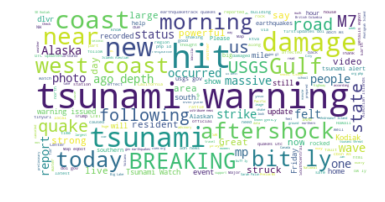

In [124]:
stopwords = set(STOPWORDS)
stopwords.update(["Alaska", "twitter", "pic", "earthquake", "Alaska", "Anchorage", "magnitude", "https", "AlaskaEarthquake"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text2)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [128]:
AK_Quake_text = " ".join(tweet for tweet in AKQuake['text'])

In [130]:
AK_Quake_text

'Holy Earthquake Batman! That one was a big one! #AKquake #hanginglightstillswinging Thanks, Obama! #AKearthquake #AKquake Back to bed. Tell me the magnitude in the morning. #akquake I hear Idaho is a nice place to live...#AKQuake Are we just supposed to go back to sleep now? #AKquake #iwassleepingsogood Just got a text from friend in Homer. Their family is heading to higher grounds right now because of tsunami warning. #AKquake #AKquake nothing damaged here by Butte. Good strong rumbles though. Two horses "are running free, having fun with traffic" near the Eagle Run Walmart. From a caller to @KFQD #akquake Many prayers and well wishes for the families and friends of our   Student-Athletes from Alaska. #akquake #alaska Well, it was as good a time as any to take Christmas decorations down... #AKquake The worst part about this #AKQuake is that now I have to clean up my room. Damn. Screw it. Gulping down an Ambien and going back to bed. Good night, Alaska! #AKQuake Stupid lib Democrats &

In [131]:
wordcloud_AKQuake = WordCloud().generate(AK_Quake_text)

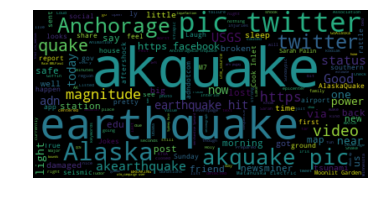

In [132]:
plt.imshow(wordcloud_AKQuake, interpolation='bilinear')
plt.axis("off")
plt.show()

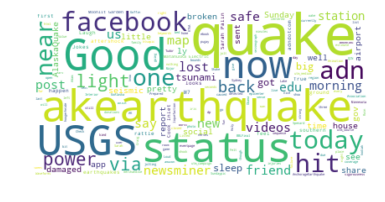

In [134]:
stopwords = set(STOPWORDS)
stopwords.update(["Alaska", "akquake", "pic", "video", "earthquake", "twitter", "Alaska", "Anchorage", "magnitude", "https", "AlaskaEarthquake"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(AK_Quake_text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [135]:
text_AKEarthquake = " ".join(tweet for tweet in AKEarthquake['text'])

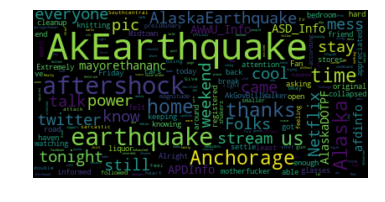

In [136]:
wordcloud_AKEarthquake = WordCloud().generate(text_AKEarthquake)

plt.imshow(wordcloud_AKEarthquake, interpolation='bilinear')
plt.axis("off")
plt.show()

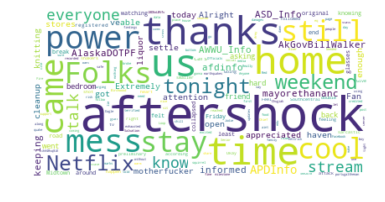

In [137]:
stopwords = set(STOPWORDS)
stopwords.update(["Alaska", "AkEarthquake", "akquake", "pic", "video", "earthquake", "twitter", "Alaska", "Anchorage", "magnitude", "https", "AlaskaEarthquake"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text_AKEarthquake)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [147]:
AKQuake['created_at']

0     1.453632e+12
1     1.453635e+12
2     1.453632e+12
3     1.453634e+12
4     1.453633e+12
5     1.516701e+12
6     1.453632e+12
7     1.543605e+12
8     1.453643e+12
9     1.453633e+12
10    1.453635e+12
11    1.453636e+12
12    1.453644e+12
13    1.544540e+12
14    1.453662e+12
15    1.543727e+12
16    1.453678e+12
17    1.453657e+12
18    1.453633e+12
19    1.516706e+12
20    1.453670e+12
21    1.453640e+12
22    1.543619e+12
23    1.494221e+12
24    1.453635e+12
25    1.453639e+12
26    1.493178e+12
27    1.543606e+12
28    1.453632e+12
29    1.453637e+12
          ...     
70    1.543606e+12
71    1.453637e+12
72    1.453654e+12
73    1.453699e+12
74    1.453739e+12
75    1.453641e+12
76    1.453916e+12
77    1.453635e+12
78    1.453655e+12
79    1.543605e+12
80    1.453632e+12
81    1.496111e+12
82    1.453664e+12
83    1.543608e+12
84    1.543607e+12
85    1.453642e+12
86    1.543613e+12
87    1.453776e+12
88    1.453671e+12
89    1.453700e+12
90    1.543617e+12
91    1.4537

<IPython.core.display.Javascript object>


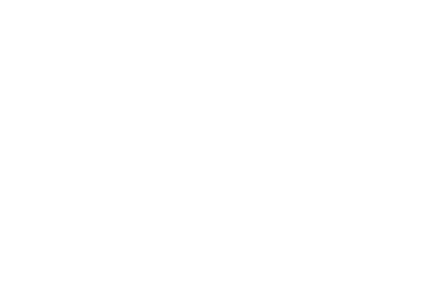

<IPython.core.display.Javascript object>


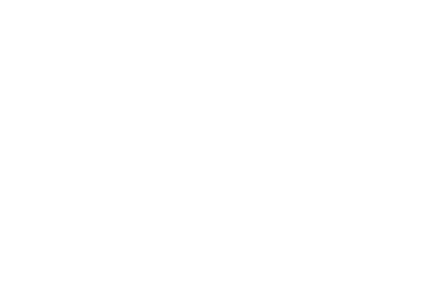

In [187]:
fig = plt.figure()

<IPython.core.display.Javascript object>


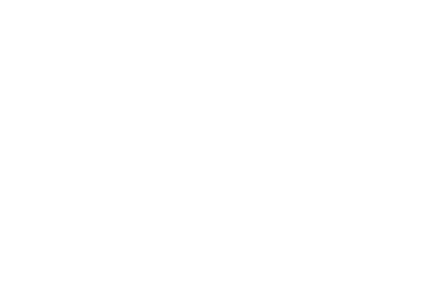

<IPython.core.display.Javascript object>


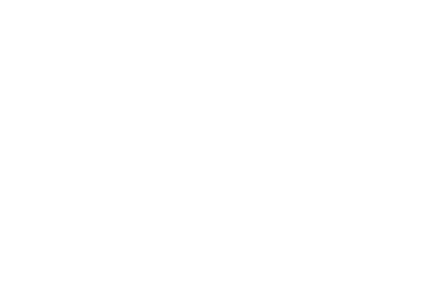

In [185]:
fig, axes = plt.subplots(2, 2)

(array([71.,  1.,  0.,  0.,  4.,  0.,  3.,  0.,  0., 21.]),
 array([1.45363189e+12, 1.46272492e+12, 1.47181795e+12, 1.48091098e+12,
        1.49000400e+12, 1.49909703e+12, 1.50819006e+12, 1.51728309e+12,
        1.52637612e+12, 1.53546915e+12, 1.54456218e+12]),
 <a list of 10 Patch objects>)

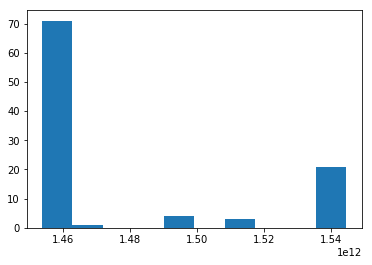

In [206]:
plt.hist(AKQuake.created_at)

(array([220.,  71.,  52.,  43.,  85., 353.,  33., 695.]),
 array([1.44318908e+12, 1.45596607e+12, 1.46874306e+12, 1.48152005e+12,
        1.49429704e+12, 1.50707403e+12, 1.51985102e+12, 1.53262801e+12,
        1.54540500e+12]),
 <a list of 8 Patch objects>)

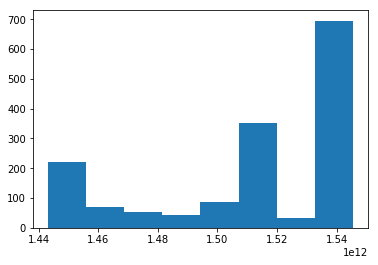

In [203]:
plt.hist(Alaska_Earthquake.created_at, bins = 8)

(array([14.,  1.,  2.,  0.,  1.,  0.,  0.,  0.,  1.,  1.]),
 array([1.54362252e+12, 1.54377593e+12, 1.54392934e+12, 1.54408275e+12,
        1.54423616e+12, 1.54438957e+12, 1.54454298e+12, 1.54469639e+12,
        1.54484980e+12, 1.54500321e+12, 1.54515662e+12]),
 <a list of 10 Patch objects>)

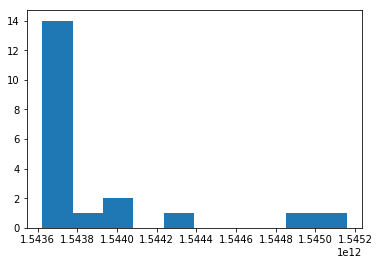

In [204]:
plt.hist(AKEarthquake.created_at)

In [207]:
Alaska_Earthquake.describe()

Unnamed: 0    created_at         likes      replies      retweets  \
count  1552.000000  1.552000e+03   1552.000000  1552.000000   1552.000000   
mean    775.500000  1.514103e+12    242.469072    13.493557    138.994845   
std     448.168123  3.368731e+10   2240.461312   104.141784    841.635350   
min       0.000000  1.443189e+12      0.000000     0.000000      0.000000   
25%     387.750000  1.494386e+12      8.000000     0.000000      6.750000   
50%     775.500000  1.516765e+12     35.000000     1.000000     25.500000   
75%    1163.250000  1.543619e+12    115.000000     7.000000     78.250000   
max    1551.000000  1.545405e+12  72348.000000  2681.000000  27715.000000   

           tweet_id       user_id  
count  1.552000e+03  1.552000e+03  
mean   9.448406e+17  8.236757e+16  
std    1.412948e+17  2.545762e+17  
min    6.474080e+17  4.283330e+05  
25%    8.621426e+17  1.983154e+07  
50%    9.560093e+17  9.411910e+07  
75%    1.068643e+18  8.017235e+08  
max    1.076133e+18  1.075584e+18

In [225]:
Alaska_Earthquake_half1 = Alaska_Earthquake[Alaska_Earthquake.created_at > 1.516765e+12]

In [226]:
len(Alaska_Earthquake_half1)

777

In [229]:
Alaska_Earthquake_half2 = Alaska_Earthquake[Alaska_Earthquake.created_at < 1.516765e+12]

In [230]:
len(Alaska_Earthquake_half2)

775

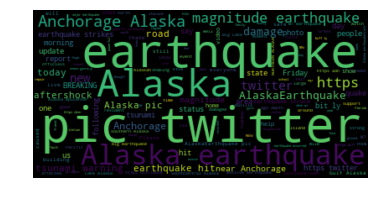

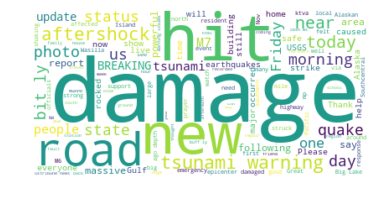

In [231]:
text_AKEarthquake_half1 = " ".join(tweet for tweet in Alaska_Earthquake_half1['text'])

wordcloud_AKEarthquake_half1 = WordCloud().generate(text_AKEarthquake_half1)

plt.imshow(wordcloud_AKEarthquake_half1, interpolation='bilinear')
plt.axis("off")
plt.show()

stopwords = set(STOPWORDS)
stopwords.update(["Alaska", "AkEarthquake", "akquake", "pic", "video", "earthquake", "twitter", "Alaska", "Anchorage", "magnitude", "https", "AlaskaEarthquake"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text_AKEarthquake_half1)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

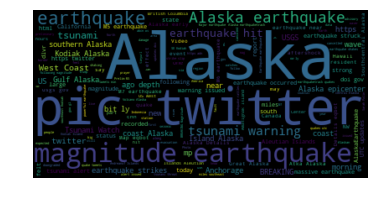

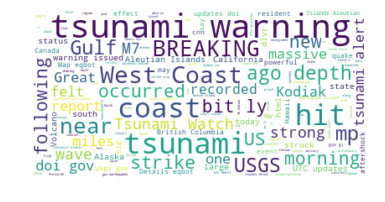

In [232]:
text_AKEarthquake_half2 = " ".join(tweet for tweet in Alaska_Earthquake_half2['text'])

wordcloud_AKEarthquake_half2 = WordCloud().generate(text_AKEarthquake_half2)

plt.imshow(wordcloud_AKEarthquake_half2, interpolation='bilinear')
plt.axis("off")
plt.show()

stopwords = set(STOPWORDS)
stopwords.update(["Alaska", "AkEarthquake", "akquake", "pic", "video", "earthquake", "twitter", "Alaska", "Anchorage", "magnitude", "https", "AlaskaEarthquake"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text_AKEarthquake_half2)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [236]:
AKQuake.describe()

Unnamed: 0    created_at       likes     replies    retweets  \
count  100.000000  1.000000e+02  100.000000  100.000000  100.000000   
mean    49.500000  1.476222e+12   16.520000    1.450000   12.790000   
std     29.011492  3.737350e+10   28.820405    2.928008   26.470603   
min      0.000000  1.453632e+12    0.000000    0.000000    0.000000   
25%     24.750000  1.453637e+12    5.000000    0.000000    3.000000   
50%     49.500000  1.453669e+12    8.000000    1.000000    5.000000   
75%     74.250000  1.496111e+12   14.000000    2.000000   10.000000   
max     99.000000  1.544562e+12  208.000000   23.000000  207.000000   

           tweet_id       user_id  
count  1.000000e+02  1.000000e+02  
mean   7.859597e+17  7.184614e+08  
std    1.567558e+17  1.213687e+09  
min    6.912084e+17  1.275509e+07  
25%    6.912307e+17  1.976946e+07  
50%    6.913658e+17  1.101872e+08  
75%    8.693786e+17  8.149394e+08  
max    1.072598e+18  4.807237e+09

In [242]:
AKQuake_half1 = AKQuake[AKQuake.created_at > 1.453669e+12]

len(AKQuake_half1)

51

In [241]:
AKQuake_half2 = AKQuake[AKQuake.created_at < 1.453669e+12]

len(AKQuake_half2)

49

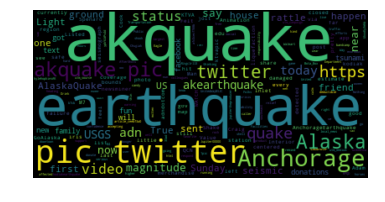

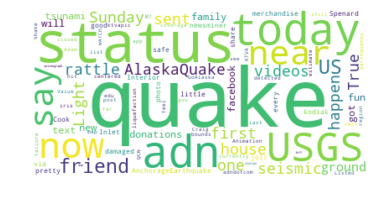

In [243]:
text_AKQuake_half1 = " ".join(tweet for tweet in AKQuake_half1['text'])

wordcloud_AKQuake_half1 = WordCloud().generate(text_AKQuake_half1)

plt.imshow(wordcloud_AKQuake_half1, interpolation='bilinear')
plt.axis("off")
plt.show()

stopwords = set(STOPWORDS)
stopwords.update(["Alaska", "AkEarthquake", "akquake", "pic", "video", "earthquake", "twitter", "Alaska", "Anchorage", "magnitude", "https", "AlaskaEarthquake"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text_AKQuake_half1)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

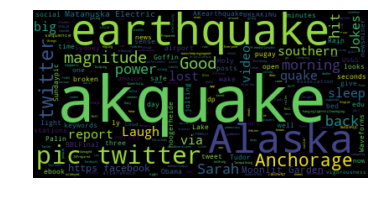

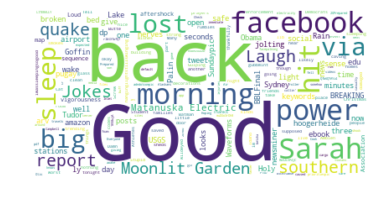

In [244]:
text_AKQuake_half2 = " ".join(tweet for tweet in AKQuake_half2['text'])

wordcloud_AKQuake_half2 = WordCloud().generate(text_AKQuake_half2)

plt.imshow(wordcloud_AKQuake_half2, interpolation='bilinear')
plt.axis("off")
plt.show()

stopwords = set(STOPWORDS)
stopwords.update(["Alaska", "AkEarthquake", "akquake", "pic", "video", "earthquake", "twitter", "Alaska", "Anchorage", "magnitude", "https", "AlaskaEarthquake"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text_AKQuake_half2)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [245]:
AKEarthquake.describe()

Unnamed: 0    created_at       likes    replies   retweets  \
count    20.00000  2.000000e+01   20.000000  20.000000  20.000000   
mean      9.50000  1.543885e+12   30.700000   2.750000  11.900000   
std       5.91608  4.525154e+08   37.042081   4.598341  23.507893   
min       0.00000  1.543623e+12    2.000000   0.000000   0.000000   
25%       4.75000  1.543647e+12   10.000000   0.000000   0.750000   
50%       9.50000  1.543670e+12   14.500000   1.000000   1.000000   
75%      14.25000  1.543870e+12   27.750000   3.000000   7.500000   
max      19.00000  1.545157e+12  130.000000  19.000000  95.000000   

           tweet_id       user_id  
count  2.000000e+01  2.000000e+01  
mean   1.069756e+18  1.703798e+09  
std    1.897987e+15  1.332163e+09  
min    1.068656e+18  6.747632e+06  
25%    1.068760e+18  2.476421e+08  
50%    1.068858e+18  2.245900e+09  
75%    1.069693e+18  2.916896e+09  
max    1.075091e+18  3.249496e+09

In [246]:
AKEarthquake_half1 = AKEarthquake[AKEarthquake.created_at > 1.543670e+12]

len(AKEarthquake_half1)

10

In [247]:
AKEarthquake_half2 = AKEarthquake[AKEarthquake.created_at < 1.543670e+12]

len(AKEarthquake_half2)

10

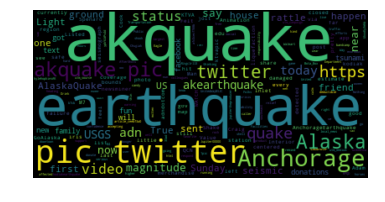

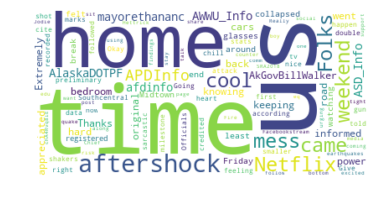

In [249]:
text_AKEarthquake_half1 = " ".join(tweet for tweet in AKEarthquake_half1['text'])

wordcloud_AKEarthquake_half1 = WordCloud().generate(text_AKEarthquake_half1)

plt.imshow(wordcloud_AKQuake_half1, interpolation='bilinear')
plt.axis("off")
plt.show()

stopwords = set(STOPWORDS)
stopwords.update(["Alaska", "AkEarthquake", "akquake", "pic", "video", "earthquake", "twitter", "Alaska", "Anchorage", "magnitude", "https", "AlaskaEarthquake"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text_AKEarthquake_half1)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

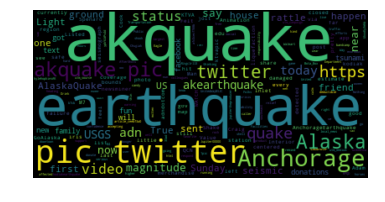

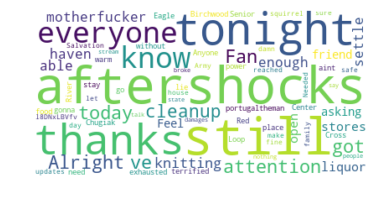

In [248]:
text_AKEarthquake_half2 = " ".join(tweet for tweet in AKEarthquake_half2['text'])

wordcloud_AKEarthquake_half2 = WordCloud().generate(text_AKEarthquake_half2)

plt.imshow(wordcloud_AKQuake_half1, interpolation='bilinear')
plt.axis("off")
plt.show()

stopwords = set(STOPWORDS)
stopwords.update(["Alaska", "AkEarthquake", "akquake", "pic", "video", "earthquake", "twitter", "Alaska", "Anchorage", "magnitude", "https", "AlaskaEarthquake"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text_AKEarthquake_half2)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Labeling

In [6]:
AKQuake = pd.read_csv(f'AKQuake.csv', low_memory=False)

Alaska_Earthquake = pd.read_csv(f'Alaska_Earthquake.csv', low_memory=False)

AKEarthquake = pd.read_csv(f'AKEarthquake.csv', low_memory=False)

In [44]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)

Had difficulty displaying the entirety of the tweet text. 

Isolating the column with (AKQuake.text) or display_all did not work - settled on list comprehension

In [8]:
def clean_tweet(tweet): 
    ''' 
    Utility function to clean tweet text by removing links, special characters 
    using simple regex statements. 
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

In [9]:
AKQ_text = AKQuake['text']

In [12]:
A_E_clean = [clean_tweet(tweet) for tweet in Alaska_Earthquake['text']]

In [14]:
type(A_E_clean)

list

In [17]:
df_AE_clean = pd.Series( (v for v in A_E_clean) )

In [21]:
df_AE_clean[0:1240].to_csv('AE_train')

In [22]:
df_AE_clean[1241:].to_csv('AE_test')

In [7]:
[text for text in AKQuake.text]

['Holy Earthquake Batman! That one was a big one! #AKquake #hanginglightstillswinging',
 'Thanks, Obama! #AKearthquake #AKquake',
 'Back to bed. Tell me the magnitude in the morning. #akquake',
 'I hear Idaho is a nice place to live...#AKQuake',
 'Are we just supposed to go back to sleep now? #AKquake #iwassleepingsogood',
 'Just got a text from friend in Homer. Their family is heading to higher grounds right now because of tsunami warning. #AKquake',
 '#AKquake nothing damaged here by Butte. Good strong rumbles though.',
 'Two horses "are running free, having fun with traffic" near the Eagle Run Walmart. From a caller to @KFQD #akquake',
 'Many prayers and well wishes for the families and friends of our   Student-Athletes from Alaska. #akquake #alaska',
 'Well, it was as good a time as any to take Christmas decorations down... #AKquake',
 'The worst part about this #AKQuake is that now I have to clean up my room. Damn.',
 'Screw it. Gulping down an Ambien and going back to bed. Good n

#### Common or significant topics

Obama, big gubbmint, lib democrates, United Way of Anchorage, okay, Alaska Department of Transportation & Public Facilities, 
USGS, Obama, Palin, Matanuska Electric Association, USGS, left wing scum, Sarah Pain

In [54]:
[text for text in AKEarthquake.text]

['.@APDInfo, @mayorethananc, @AWWU_Info, @afdinfo, @ASD_Info, @AlaskaDOTPF, & @AkGovBillWalker: Thanks for keeping us informed. Extremely appreciated. #AkEarthquake',
 'Alright aftershocks. You’ve got my attention. \n\nNot.  A.  Fan. \n#akearthquake #AlaskaEarthquake',
 'With all the earthquake and aftershocks today, after cleanup I should have been knitting like a motherfucker, but I haven’t been able to settle down enough. #AkEarthquake',
 'Who knows which liquor stores are open asking for a friend #AKearthquake #anchorage',
 'When I went into my bedroom after the power came back on, I had a hard time knowing what was earthquake mess and what was original mess.  #AkEarthquake',
 'Folks in cars when road collapsed, ‘this is the end’/folks at home watching glasses break, ‘at least it’s Friday’',
 'That aftershock around 10 a.m. we felt here in Midtown Anchorage registered at a preliminary magnitude of 4.8, according to @AKearthquake, followed by a few smaller shakers. How are you feeli

#### Common or meaningful topics

Mayor Ethan Anc, AK Gov Bill Walker, Officials, Netflix

In [59]:
Alaska_Earthquake

Unnamed: 0    created_at  likes  replies  retweets  \
0              0  1.545405e+12      0        0         1   
1              1  1.544998e+12    130        6        95   
2              2  1.545239e+12      0        0         0   
3              3  1.545374e+12      0        0         0   
4              4  1.545341e+12      0        0         0   
5              5  1.545099e+12     32        0        21   
6              6  1.545341e+12      0        0         0   
7              7  1.545328e+12     31        7        40   
8              8  1.545330e+12      1        0         0   
9              9  1.545337e+12      1        0         0   
10            10  1.545328e+12      0        0         0   
11            11  1.545265e+12      0        0         0   
12            12  1.545332e+12      0        0         0   
13            13  1.545374e+12      3        0         0   
14            14  1.545286e+12      0        0         0   
15            15  1.545382e+12      1        0         3   
16            16  1.545381e+12      3        0         1   
17            17  1.545381e+12      3        0         2   
18            18  1.545328e+12      0        0         0   
19            19  1.545328e+12      0        0         0   
20            20  1.545392e+12      1        0         1   
21            21  1.545351e+12      4        0         0   
22            22  1.545315e+12      0        0         0   
23            23  1.545283e+12     83        3        63   
24            24  1.545255e+12     13        0        10   
25            25  1.545185e+12    671        6       162   
26            26  1.545127e+12      0        0         0   
27            27  1.545101e+12      0        0         0   
28            28  1.545080e+12      0        0         0   
29            29  1.545066e+12      0        0         0   
...          ...           ...    ...      ...       ...   
1522        1522  1.446983e+12     19        0        59   
1523        1523  1.446983e+12      3        0         5   
1524        1524  1.446980e+12     14        0        46   
1525        1525  1.446854e+12      2        0         6   
1526        1526  1.446820e+12     18        1        13   
1527        1527  1.446820e+12      5        2         2   
1528        1528  1.446820e+12      6        0         1   
1529        1529  1.446773e+12     21        0        40   
1530        1530  1.446393e+12      7        1        27   
1531        1531  1.446138e+12     32       14        50   
1532        1532  1.446088e+12      5        0         7   
1533        1533  1.445757e+12     25        0        21   
1534        1534  1.445280e+12      5        0        12   
1535        1535  1.445208e+12     19        2         1   
1536        1536  1.444075e+12      2        0         4   
1537        1537  1.444074e+12      3        0         8   
1538        1538  1.444071e+12      1        0         4   
1539        1539  1.444070e+12      0        0         2   
1540        1540  1.444070e+12      2        0         2   
1541        1541  1.444069e+12      0        0         1   
1542        1542  1.444068e+12      1        0         3   
1543        1543  1.444067e+12      3        0         8   
1544        1544  1.444067e+12     27        1        45   
1545        1545  1.444055e+12      0        0         1   
1546        1546  1.444032e+12      0        0         1   
1547        1547  1.444032e+12      0        0         1   
1548        1548  1.443653e+12      2        0         6   
1549        1549  1.443578e+12      2        0         2   
1550        1550  1.443425e+12      1        0         0   
1551        1551  1.443189e+12      0        0         1   

                                                   text             tweet_id  \
0     2.0 magnitude #earthquake. 112km SW of Anchor ...  1076132704599633921   
1     Here's a milestone. 2018 marks the first time ...  1074426144764583937   
2     Amidst last month's earthquake, this #p

In [56]:
[text for text in Alaska_Earthquake.text]

['2.0 magnitude #earthquake. 112km SW of Anchor Point, Alaska http://www.earthquaketrack.com/quakes/2018-12-21-15-01-36-utc-2-0-73\xa0…',
 "Here's a milestone. 2018 marks the first time we have ever recorded 50,000 earthquakes in Alaska. There's an earthquake counter at the bottom of our home page, http://earthquake.alaska.edu\xa0, if you want to follow along.pic.twitter.com/chA4Rvq8iE",
 "Amidst last month's earthquake, this #prolife pregnancy center provided diapers and other emergency needs to #Alaska families. | After the Earthquake: Alaska Pregnancy Center Spared from Destruction http://bit.ly/2Ev3J4t\xa0 via @PHC_Newspic.twitter.com/Autne7T8k3",
 '3.0 magnitude #earthquake. 84km SSW of Shishmaref, Alaska http://www.earthquaketrack.com/quakes/2018-12-21-06-16-51-utc-3-0-4\xa0…',
 'Who caused that earthquake in Russia, did USA ???? As they did in Alaska a few weeks ago ',
 "As you prepare for the holidays, it's also a good time to be sure you're prepared for the next earthquake. Fo

#### Common or meaningful topics

prolife pregnancy center, Russia, #ACA, Alaska DOT, MET Squad/team, GEER team, Jeep, Lisa Murkowski, Geologic Materials Center, BP Foundation, Red Cross of Alaska, Wells Fargo, DOT, Road Crews, Alaska Railroad, Native Women, Sara Palin, Liberal, State Workers, Mayor Berkowitz, Trump, Bush, Gov-elect Dunleavy, President, aid, Trans Alaska Pipeline, FEMA, White House, Liberals, Pelos, Waters, Schumer, Ocasio Cortez, California, POTUS, God, Border, Troops, Dan Sullivan, Police, Indian, Native, 

Government | USGS, Trump, Alaska Earthquake Center, Palin, Murkowski, Walker, DOT

Business | BP, ExxonMobil, Alyeska Pipeline, Jeep

Philanthropic | Red Cross (Alaska), Salvation Army, United Way of Anchorage, The Foraker Group

In [73]:
Act_Cat = ['Government', 'Business', 'Philanthropic']

In [74]:
Actors = pd.DataFrame(index=Act_Cat, columns = ['Members'])

In [ ]:
Actors.iloc[0][0] = 'USGS, Trump, Alaska Earthquake Center, Palin, Murkowski, Walker, DOT'

In [91]:
Actors.iloc[1][0] = 'BP, ExxonMobil, Alyeska Pipeline, Jeep'

In [94]:
Actors.iloc[2][0] = 'Red Cross (Alaska), Salvation Army, United Way of Anchorage, The Foraker Group'

In [102]:
pd.set_option('display.max_colwidth', -1)

In [103]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(Actors)

Members
Government     USGS, Trump, Alaska Earthquake Center, Palin, Murkowski, Walker, DOT          
Business       BP, ExxonMobil, Alyeska Pipeline, Jeep                                        
Philanthropic  Red Cross (Alaska), Salvation Army, United Way of Anchorage, The Foraker Group

# Sentiment Analysis

## Tweepy + TextBlob 

From here: https://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/

In [112]:
class TwitterClient(object): 
    ''' 
    Generic Twitter Class for sentiment analysis. 
    '''
    def __init__(self): 
        ''' 
        Class constructor or initialization method. 
        '''
        # keys and tokens from the Twitter Dev Console 
        consumer_key = 'w9ZAiaxXRLv8hK5Ogf3T359ni'
        consumer_secret = 'l6MREVo4VRSqiohUiCQtuXB5yVLpKsx26psqoOfuMRNH8r2drf'
        access_token = '1074584667997622272-Aur1m9nU45NYjRhTahzQUqITr5KIkU'
        access_token_secret = 'iVSUXtHebYhEhE0TJwXEAHYNC2pj2kYKz2CifwYbtc6he'
  
        # attempt authentication 
        try: 
            # create OAuthHandler object 
            self.auth = OAuthHandler(consumer_key, consumer_secret) 
            # set access token and secret 
            self.auth.set_access_token(access_token, access_token_secret) 
            # create tweepy API object to fetch tweets 
            self.api = tweepy.API(self.auth) 
        except: 
            print("Error: Authentication Failed") 
  
    def clean_tweet(self, tweet): 
        ''' 
        Utility function to clean tweet text by removing links, special characters 
        using simple regex statements. 
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
    
    def get_tweet_sentiment(self, tweet): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(self.clean_tweet(tweet)) 
        # set sentiment 
        if analysis.sentiment.polarity > 0: 
            return 'positive'
        elif analysis.sentiment.polarity == 0: 
            return 'neutral'
        else: 
            return 'negative'
  
    def get_tweets(self, query, count = 10): 
        ''' 
        Main function to fetch tweets and parse them. 
        '''
        # empty list to store parsed tweets 
        tweets = [] 
        
        try: 
            # call twitter api to fetch tweets 
            fetched_tweets = self.api.search(q = query, count = count) 
  
            # parsing tweets one by one 
            for tweet in fetched_tweets: 
                # empty dictionary to store required params of a tweet 
                parsed_tweet = {} 
  
                # saving text of tweet 
                parsed_tweet['text'] = tweet.text 
                # saving sentiment of tweet 
                parsed_tweet['sentiment'] = self.get_tweet_sentiment(tweet.text) 
  
                # appending parsed tweet to tweets list 
                if tweet.retweet_count > 0: 
                    # if tweet has retweets, ensure that it is appended only once 
                    if parsed_tweet not in tweets: 
                        tweets.append(parsed_tweet) 
                else: 
                    tweets.append(parsed_tweet) 
  
            # return parsed tweets 
            return tweets 
  
        except tweepy.TweepError as e: 
            # print error (if any) 
            print("Error : " + str(e)) 
                               
def main(): 
    # creating object of TwitterClient Class 
    api = TwitterClient() 
    # calling function to get tweets 
    tweets = api.get_tweets(query = 'Alaska Earthquake', count = 2000) 
  
    print("{} tweets analyzed".format(len(tweets)))

    # picking positive tweets from tweets 
    ptweets = [tweet for tweet in tweets if tweet['sentiment'] == 'positive'] 
    # percentage of positive tweets 
    print("Positive tweets percentage: {} %".format(100*len(ptweets)/len(tweets))) 
    # picking negative tweets from tweets 
    ntweets = [tweet for tweet in tweets if tweet['sentiment'] == 'negative'] 
    # percentage of negative tweets 
    print("Negative tweets percentage: {} %".format(100*len(ntweets)/len(tweets))) 
    # percentage of neutral tweets 
    print("Neutral tweets percentage: {} %".format(100*(len(tweets) - len(ntweets) - len(ptweets))/len(tweets))) 
  
    # printing first 5 positive tweets 
    print("\n\nPositive tweets:") 
    for tweet in ptweets[:10]: 
        print(tweet['text']) 
  
    # printing first 5 negative tweets 
    print("\n\nNegative tweets:") 
    for tweet in ntweets[:10]: 
        print(tweet['text'])
    
    # returning manipulable data
    data = []
    for tweet in tweets:
        data.append(tweet)
    return data
        
if __name__ == "__main__": 
    # calling main function 
    main()

83 tweets analyzed
Positive tweets percentage: 14.457831325301205 %
Negative tweets percentage: 0.0 %
Neutral tweets percentage: 85.5421686746988 %


Positive tweets:
RT @dahboo7: Strong Earthquakes Hit #Indonesia, #Alaska, #Brazil and #Yellowstone's Old Faithful #Breaking #Earthquake... https://t.co/ZSZj…
RT @littlebytesnews: Both the ground and the residents of Alaska were rattled on Friday morning by a powerful 7.0 magnitude earthquake. The…
Both the ground and the residents of Alaska were rattled on Friday morning by a powerful 7.0 magnitude earthquake.… https://t.co/FZ43u0uvYG
THE FORERUNNER?: Alaska’s 7.0 Magnitude Earthquake Could Be First of Many Powerful Quakes To Rattle USA… https://t.co/wbE9ZsiBqp
How Alaska fixed its earthquake-shattered roads in just days #DMZRoadrunner https://t.co/bsPfWoLdj8   #DMZBringBackGlass
RT @Jesus_Ready_Org: BIRTH PANGS: On Friday, November 30, a magnitude 7.0 earthquake struck Anchorage, Alaska. The initial jarring was dest…
6.6 Indonesia Is The

## Selenium + TextBlob

In [23]:
def clean_tweet(tweet): 
    ''' 
    Utility function to clean tweet text by removing links, special characters 
    using simple regex statements. 
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

In [41]:
def get_tweet_sentiment(tweet): 
    ''' 
    Utility function to classify sentiment of passed tweet 
    using textblob's sentiment method 
    '''
    # create TextBlob object of passed tweet text 
    analysis = TextBlob(tweet) 
    # set sentiment 
    if analysis.sentiment.polarity > 0: 
        return 'positive'
    elif analysis.sentiment.polarity == 0: 
        return 'neutral'
    else: 
        return 'negative'

In [114]:
A_E_clean = [clean_tweet(tweet) for tweet in Alaska_Earthquake['text']]

A_E_sentiment = [get_tweet_sentiment(tweet) for tweet in A_E_clean]

Alaska_Earthquake['sentiment'] = A_E_sentiment

In [115]:
AKQuake_clean = [clean_tweet(tweet) for tweet in AKQuake['text']]

AKQuake_sentiment = [get_tweet_sentiment(tweet) for tweet in AKQuake_clean]

AKQuake['sentiment'] = AKQuake_sentiment

In [113]:
AKEarthquake_clean = [clean_tweet(tweet) for tweet in AKEarthquake['text']]

AKEarthquake_sentiment = [get_tweet_sentiment(tweet) for tweet in AKEarthquake_clean]

AKEarthquake['sentiment'] = AKEarthquake_sentiment

In [117]:
def analyze(tweets):
    tweets_clean = [clean_tweet(tweet) for tweet in tweets['text']]
    tweets_sentiment = [get_tweet_sentiment(tweet) for tweet in tweets_clean]
    tweets['sentiment'] = tweets_sentiment
    tweets_analyzed = tweets
    return tweets_analyzed

In [128]:
if __name__ == "__main__":
 
    # start a driver for a web browser:
    driver = init_driver()
 
    # log in to twitter (replace username/password with your own):
    username = 'chylirk@gmail.com'
    password = 'DisasterProject'
    login_twitter(driver, username, password)
 
    # search twitter:
    query = "White Fragility"
    page_source = search_twitter(driver, query)
 
    # extract info from the search results:
    tweets = extract_tweets(page_source)
    
    df = pd.DataFrame(tweets)
    
    df_analyzed = analyze(df)
         
    # ==============================================
    # add in any other functions here
    # maybe some analysis functions
    # maybe a function to write the info to file
    # ==============================================
 
    # close the driver:
    close_driver(driver)

In [139]:
len(df_analyzed[df_analyzed.sentiment == 'positive'])

442

In [140]:
len(df_analyzed[df_analyzed.sentiment == 'negative'])

320

In [141]:
len(df_analyzed[df_analyzed.sentiment == 'neutral'])

321

## Label Data

In [8]:
AE_data = pd.read_csv(f'AE_data_1000.csv', low_memory=False)

In [9]:
AE_data = AE_data[0:999]

In [10]:
AE_train = AE_data.sort_values(by=['0.1'])

In [11]:
AE_train = AE_train.reset_index(drop=True)

In [12]:
AE_train = AE_train.drop(columns=['0'])

In [13]:
AE_train = AE_train.rename(index=str, columns={"2 0 magnitude earthquake 112km SW of Anchor Point Alaska": "text", "0.1": "sentiment"})

In [14]:
AE_trn = AE_train.iloc[:,:1]

In [15]:
AE_trn_y = AE_train.iloc[:, 1:]

In [16]:
trn = AE_trn.iloc[:,0]

In [17]:
trn_y = AE_trn_y.iloc[:,0]

In [18]:
trn.to_csv('trn.csv')

In [19]:
trn_y.to_csv('trn_y.csv')

### Data Dictionary

In [21]:
AE_train['pre_clean_len'] = [len(t) for t in AE_train.text]

In [22]:
data_dict = {
    'sentiment': {
        'type': AE_train.sentiment.dtype,
        'descrption': 'sentiment class - -1: negative, 1: positive'
    },
    'text': {
        'type': AE_train.text.dtype,
        'description': 'tweet text'
    },
    'pre_clean_len': {
        'type': AE_train.pre_clean_len.dtype,
        'description': 'Length of the tweet before cleaning'
    },
    'dataset_shape': AE_train.shape
}

pprint(data_dict)

NameError: name 'pprint' is not defined

<function matplotlib.pyplot.show(*args, **kw)>

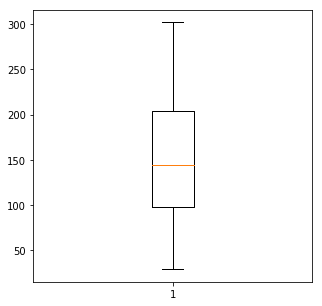

In [172]:
fig, ax = plt.subplots(figsize = (5,5))
plt.boxplot(AE_train.pre_clean_len)
plt.show

In [23]:
dirty = [text for text in AE_train[AE_train.pre_clean_len > 280].text]

In [24]:
clean = [re.sub(r'pic twitter com [A-Za-z0-9./]+','', t) for t in AE_train.text]

In [25]:
AE_train_clean = AE_train.copy()

In [26]:
AE_train_clean['text'] = clean

In [27]:
AE_train_clean['pre_clean_len'] = [len(t) for t in AE_train_clean.text]

In [28]:
fig, ax = plt.subplots(figsize = (5,5))
plt.boxplot(AE_train_clean.pre_clean_len)
plt.show

NameError: name 'plt' is not defined

In [29]:
AE_train_clean.to_csv('AE_train_clean.csv')

AE_train_clean represents a fraction of the entire 'Alaska Earthquake' results (399/1500) - but it has sentiment included, and twitter pic links have been removed

In [30]:
my_df = pd.read_csv('AE_train_clean.csv',index_col=0)
my_df.head()

text  sentiment  pre_clean_len
0  YIKES Damage seen after powerful earthquake th...       -1.0            112
1  Musn t be many trees in Alaska that caused the...       -1.0             98
2  Aww shucks Thanks Individual 1 but maybe you c...       -1.0            239
3                 Oh what a night Alaska earthquake        -1.0             34
4  Lived in Alaska my entire life and this is the...       -1.0            132

In [31]:
len(my_df)

999

In [32]:
my_df = my_df.drop([998])

In [33]:
my_df

text  sentiment  \
0    YIKES Damage seen after powerful earthquake th...       -1.0   
1    Musn t be many trees in Alaska that caused the...       -1.0   
2    Aww shucks Thanks Individual 1 but maybe you c...       -1.0   
3                   Oh what a night Alaska earthquake        -1.0   
4    Lived in Alaska my entire life and this is the...       -1.0   
5    Nevada s critically endangered pupfish are in ...       -1.0   
6    Alaska s earthquake caused endangered desert p...       -1.0   
7    There have been 144 AFTERSHOCKS in the 12 hour...       -1.0   
8    Omg LIVE UPDATES Alaska Rocked After Major Ear...       -1.0   
9    JUST AHEAD ON Anchorage Alaska is still reelin...       -1.0   
10   7 2 magnitude Alaska earthquake ruptures roads...       -1.0   
11   UPDATE 7 0 earthquake and aftershocks in Alask...       -1.0   
12   Alaska wouldn t have suffered through such a t...       -1.0   
13   From buckled roads to collapsing ceilings the ...       -1.0   
14   Alaska Ring of FIRE earthquake triggers DEVAST...       -1.0   
15   Person breathes Alaskans Idk I m just kinda tr...       -1.0   
16   Forget any real news today No news on the cara...       -1.0   
17   Earthquake strikes Alaska as BIG ONE fears gro...       -1.0   
18   Seven years ago today wrote these words A powe...       -1.0   
19   I have lived in Alaska for almost 20 years and...       -1.0   
20   An atmospheric research experiment has become ...       -1.0   
21   The earthquake in Anchorage Alaska along with ...       -1.0   
22   No it has not I think this is actually a big d...       -1.0   
23   I took these pictures of the Turnagain subdivi...       -1.0   
24   1964 U S a 9 2 earthquake struck Alaska killin...       -1.0   
25   From buckled roads to collapsing ceilings the ...       -1.0   
26   Video shows people scrambling to take cover du...       -1.0   
27   Today is the 54th anniversary of the 1964 Alas...       -1.0   
28   The Extreme damage done by Alaska M7 0 Earthqu...       -1.0   
29   Sarah Palin s house was reportedly damaged in ...       -1.0   
..                                                 ...        ...   
968  Our buildings are made to last Check out this ...        1.0   
969  Footage shows the moment a woman and her son b...        1.0   
970  Watch a Jeep CJ 7 beast mode this Alaska road ...        1.0   
971  Per Anchorage Waste Water Utility all tested s...        1.0   
972  The supply chain of food and other goods into ...        1.0   
973  Alaska repairs earthquake damaged roads in rec...        1.0   
974  The huge quake that hit Anchorage this month c...        1.0   
975  Happy 65 years to KTVA yesterday lol It s so c...        1.0   
976  It s good to hear that the tsunami warning fol...        1.0   
977  Great to see our Alaska NECA Contractors comin...        1.0   
978  UPDATE from Kodiak Facebook Tsunami ddowngrade...        1.0   
979  The phantom M7 hung up production of the GMV b...        1.0   
980  would like to give our most sincere thanks to ...        1.0   
981  So far so good up here in Alaska No reports of...        1.0   
982  The AATA would like to thank all Alaska Athlet...        1.0   
983  The magnitude 7 0 earthquake that struck Alask...        1.0   
984  Overall good news for Alaska with the downgrad...        1.0   
985  Let s keep the people of Alaska in prayer foll...        1.0   
986  How were roads in Alaska repaired so quickly a...        1.0   
987  Alaska nursing homes safe despite public safet...        1.0   
988  Alaska repairs earthquake damaged roads in rec...        1.0   
989  Watch this Jeep Wrangler CJ 7 take on this tor...        1.0   
990  For everyone reaching out my family and friend...        1.0   
991  Lisa Murkowski Alaska from the US Senate discu...        1.0   
992  Please join me in praying for everyone impacte...        1.0   
993  great to see that the Geologic Materials Cente...        1.0   
994  Well that was fun alaskastrong alaska alask

### Build WordClouds for Positive/Negative/Neutral Tweets

In [81]:
neg_tweets = my_df[my_df.sentiment == -1]

In [82]:
neg_string = []

In [83]:
for t in neg_tweets.text:
    neg_string.append(t)

neg_string = pd.Series(neg_string).str.cat(sep=' ')

In [84]:
stopwords = set(STOPWORDS)
stopwords.update(["Alaska", "alaska", "alaskaearthquake", "twitter", "pic", "earthquake", "Alaska", "Anchorage", "anchorage", "magnitude", "https", "AlaskaEarthquake"])

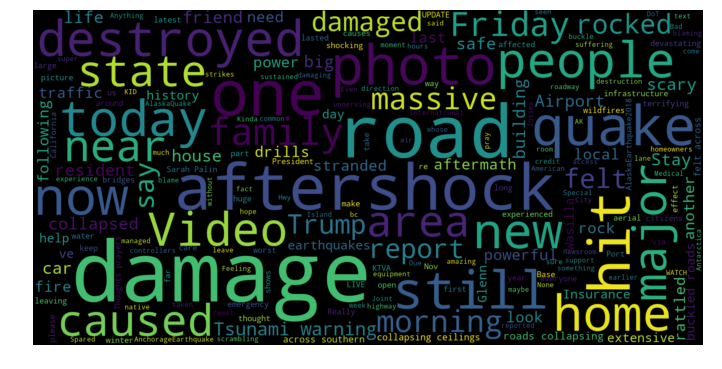

In [85]:
wordcloud = WordCloud(stopwords=stopwords, width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [87]:
for t in neg_tweets.text:
    if 'photo' in t:
        print(t)

The photos of destruction from the Alaska earthquake are so haunting
Extremely scary earthquake up in Alaska Some of the photos are shocking Thoughts and prayers with all of those affected Anchorage Alaska 
Saddest photo from Alaska earthquake so far 
This aerial photo shows damage on Vine Road south of Wasilla Alaska after a magnitude 7 0 earthquake 
My heart goes out to the people of Anchorage Alaska after today s 7 0 earthquake Some of the photos and videos coming in are really incredible Stay safe
Check out these incredible photos of where the ground ripped in half during the Alaska earthquake It seems like there was more slope failure around Anchorage than geologists would have expected


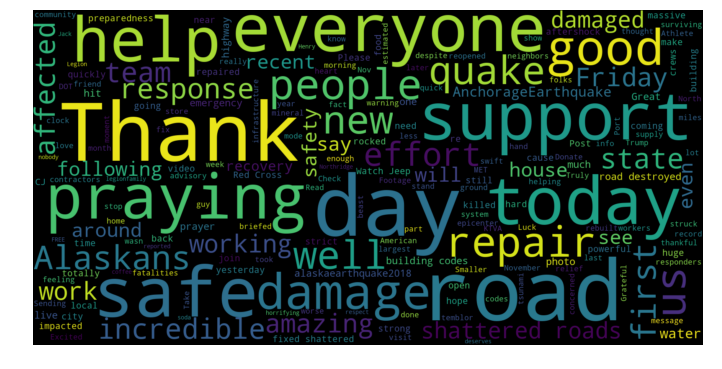

In [88]:
pos_tweets = my_df[my_df.sentiment == 1]

pos_string = []

for t in pos_tweets.text:
    pos_string.append(t)

pos_string = pd.Series(pos_string).str.cat(sep=' ')

from wordcloud import WordCloud

wordcloud = WordCloud(stopwords=stopwords, width=1600, height=800,max_font_size=200).generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

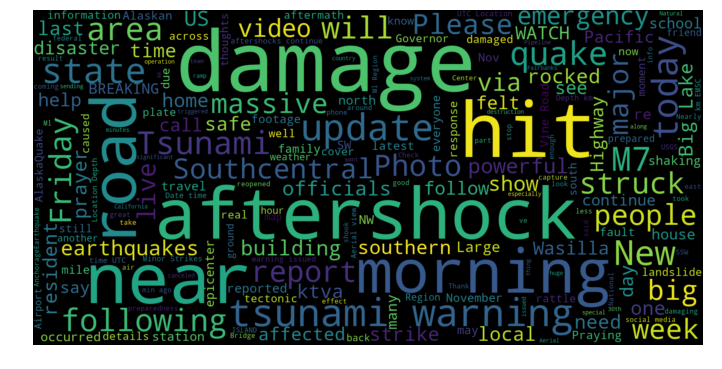

In [89]:
neu_tweets = my_df[my_df.sentiment == 0]

neu_string = []

for t in neu_tweets.text:
    neu_string.append(t)

neu_string = pd.Series(neu_string).str.cat(sep=' ')

from wordcloud import WordCloud

wordcloud = WordCloud(stopwords=stopwords, width=1600, height=800,max_font_size=200).generate(neu_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### CountVectorizer with Stopwords

In [186]:
cvec = CountVectorizer()

In [187]:
cvec.fit(my_df.text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [188]:
len(cvec.get_feature_names())

3517

In [189]:
neg_doc_matrix = cvec.transform(my_df[my_df.sentiment == -1].text)
neu_doc_matrix = cvec.transform(my_df[my_df.sentiment == 0].text)
pos_doc_matrix = cvec.transform(my_df[my_df.sentiment == 1].text)

In [190]:
neg_tf = np.sum(neg_doc_matrix, axis=0)
neu_tf = np.sum(neu_doc_matrix, axis=0)
pos_tf = np.sum(pos_doc_matrix, axis=0)

In [191]:
neg = np.squeeze(np.asarray(neg_tf))
neu = np.squeeze(np.asarray(neu_tf))
pos = np.squeeze(np.asarray(pos_tf))

In [192]:
term_freq_df = pd.DataFrame([neg, neu, pos], columns = cvec.get_feature_names()).transpose()

In [193]:
term_freq_df['total'] = term_freq_df[0] + term_freq_df[1] + term_freq_df[2]

Text(0.5, 1.0, 'Top 500 tokens in tweets')

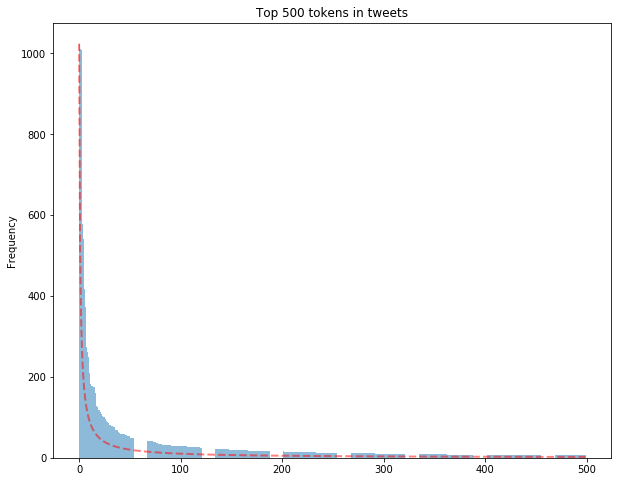

In [194]:
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets')

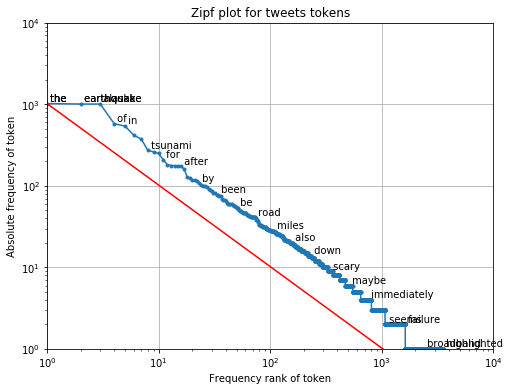

In [195]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**4)
plt.xlim(1,10**4)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

Text(0.5, 1.0, 'Top 50 tokens in negative tweets')

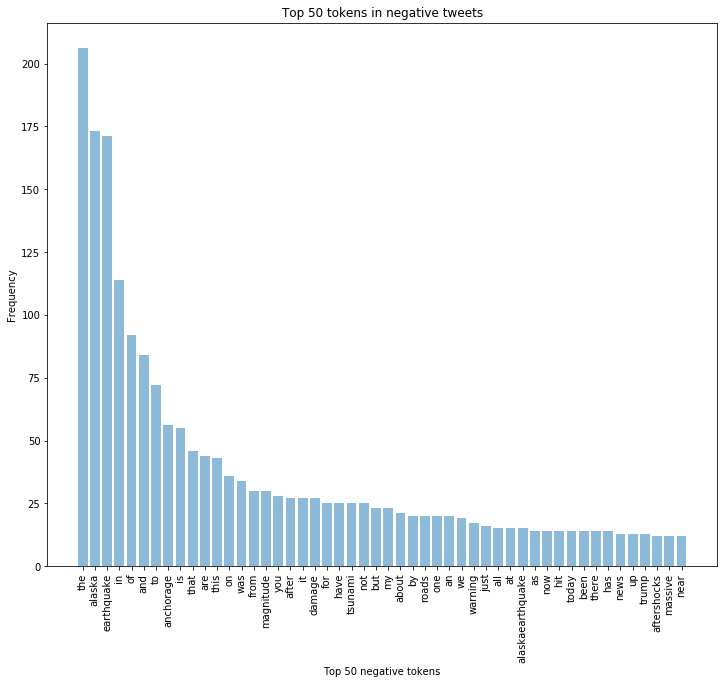

In [197]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by=0, ascending=False)[0][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by=0, ascending=False)[0][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets')

### CountVectorizer without Stopwords

In [198]:
cvec = CountVectorizer(stop_words=stopwords)

In [79]:
cvec.fit(my_df.text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [80]:
len(cvec.get_feature_names())

3517

In [81]:
neg_doc_matrix = cvec.transform(my_df[my_df.sentiment == -1].text)
neu_doc_matrix = cvec.transform(my_df[my_df.sentiment == 0].text)
pos_doc_matrix = cvec.transform(my_df[my_df.sentiment == 1].text)

In [82]:
neg_tf = np.sum(neg_doc_matrix, axis=0)
neu_tf = np.sum(neu_doc_matrix, axis=0)
pos_tf = np.sum(pos_doc_matrix, axis=0)

In [83]:
neg = np.squeeze(np.asarray(neg_tf))
neu = np.squeeze(np.asarray(neu_tf))
pos = np.squeeze(np.asarray(pos_tf))

In [84]:
term_freq_df2 = pd.DataFrame([neg, neu, pos], columns = cvec.get_feature_names()).transpose()

In [86]:
term_freq_df2['total'] = term_freq_df2[0] + term_freq_df2[1] + term_freq_df2[2]

Text(0.5, 1.0, 'Top 500 tokens in tweets')

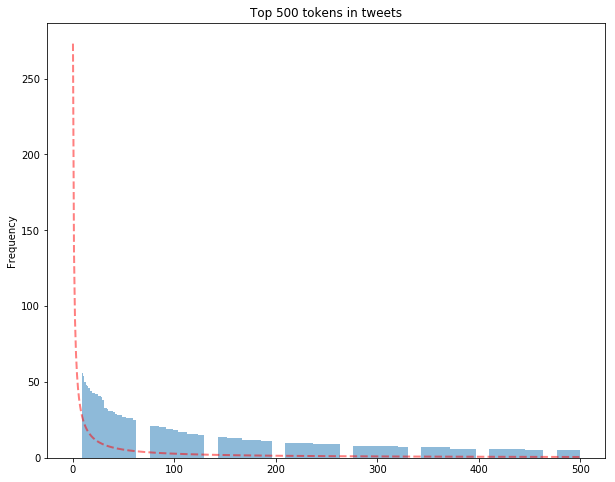

In [206]:
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df2.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df2.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets')

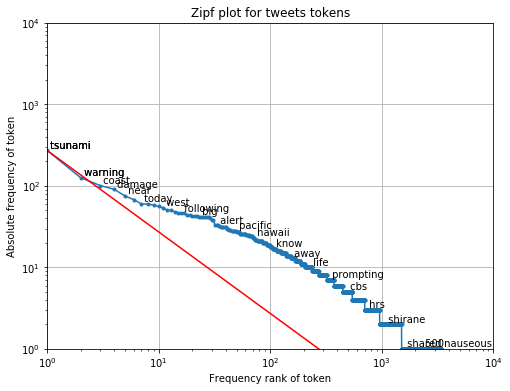

In [207]:
from pylab import *
counts = term_freq_df2.total
tokens = term_freq_df2.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**4)
plt.xlim(1,10**4)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

### Pos/Neg Charts

Text(0.5, 1.0, 'Top 50 tokens in negative tweets')

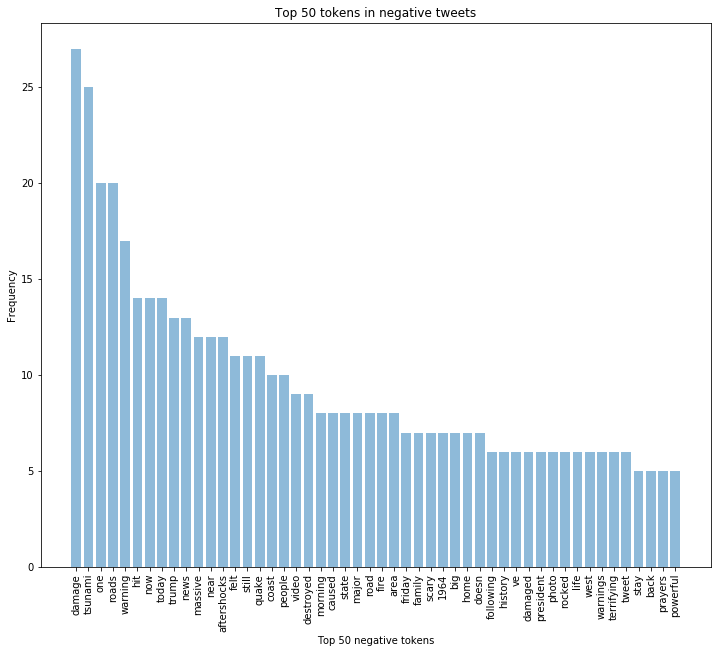

In [208]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by=0, ascending=False)[0][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by=0, ascending=False)[0][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets')

Text(0.5, 1.0, 'Top 50 tokens in positive tweets')

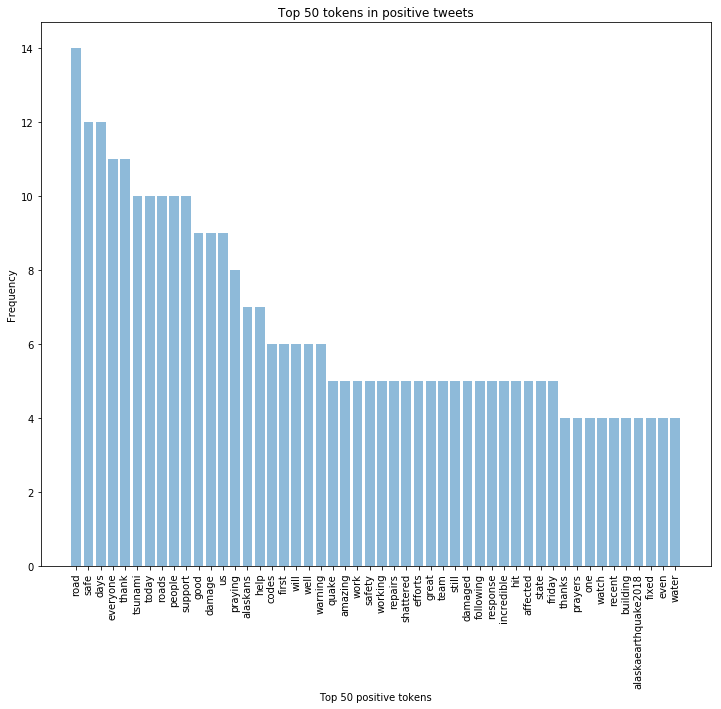

In [209]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by=2, ascending=False)[2][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by=2, ascending=False)[2][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets')

In [210]:
term_freq_df2['pos_rate'] = term_freq_df2[2] * 1./term_freq_df2['total']
term_freq_df2.sort_values(by='pos_rate', ascending=False).iloc[:10]

0  1  2  total  pos_rate
donated                                         0  0  1      1       1.0
distracted                                      0  0  1      1       1.0
sdepartmentoftransportationandpublicfacilities  0  0  1      1       1.0
discussing                                      0  0  1      1       1.0
seawolf                                         0  0  1      1       1.0
seawolves                                       0  0  1      1       1.0
diligently                                      0  0  1      1       1.0
seemed                                          0  0  1      1       1.0
develop                                         0  0  1      1       1.0
detection                                       0  0  1      1       1.0

In [211]:
term_freq_df2['pos_freq_pct'] = term_freq_df2[2] * 1./term_freq_df2[2].sum()
term_freq_df2.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]

0    1   2  total  pos_rate  pos_freq_pct
road       8   19  14     41  0.341463      0.010518
safe       5   14  12     31  0.387097      0.009016
days       2    8  12     22  0.545455      0.009016
everyone   4   11  11     26  0.423077      0.008264
thank      1    2  11     14  0.785714      0.008264
tsunami   25  238  10    273  0.036630      0.007513
today     14   36  10     60  0.166667      0.007513
roads     20   17  10     47  0.212766      0.007513
people    10   18  10     38  0.263158      0.007513
support    2    3  10     15  0.666667      0.007513

In [212]:
from scipy.stats import hmean

term_freq_df2['pos_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']])                                                               if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 else 0), axis=1)
                                                       
term_freq_df2.sort_values(by='pos_hmean', ascending=False).iloc[:10]

0   1   2  total  pos_rate  pos_freq_pct  pos_hmean
road       8  19  14     41  0.341463      0.010518   0.020408
days       2   8  12     22  0.545455      0.009016   0.017738
safe       5  14  12     31  0.387097      0.009016   0.017621
thank      1   2  11     14  0.785714      0.008264   0.016357
everyone   4  11  11     26  0.423077      0.008264   0.016212
support    2   3  10     15  0.666667      0.007513   0.014859
people    10  18  10     38  0.263158      0.007513   0.014609
roads     20  17  10     47  0.212766      0.007513   0.014514
today     14  36  10     60  0.166667      0.007513   0.014378
good       1   9   9     19  0.473684      0.006762   0.013333

In [213]:
from scipy.stats import norm

def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])

term_freq_df2['pos_freq_pct_normcdf'] = normcdf(term_freq_df2['pos_freq_pct'])

term_freq_df2['pos_normcdf_hmean'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_pct_normcdf']])

term_freq_df2.sort_values(by='pos_normcdf_hmean',ascending=False).iloc[:10]

0  1   2  total  pos_rate  pos_freq_pct  pos_hmean  \
fixed      0  0   4      4  1.000000      0.003005   0.005993   
codes      0  1   6      7  0.857143      0.004508   0.008969   
food       0  0   3      3  1.000000      0.002254   0.004498   
strict     0  0   3      3  1.000000      0.002254   0.004498   
quickly    0  0   3      3  1.000000      0.002254   0.004498   
shattered  1  0   5      6  0.833333      0.003757   0.007479   
repairs    0  1   5      6  0.833333      0.003757   0.007479   
thank      1  2  11     14  0.785714      0.008264   0.016357   
totally    1  0   3      4  0.750000      0.002254   0.004494   
join       0  1   3      4  0.750000      0.002254   0.004494   

           pos_rate_normcdf  pos_freq_pct_normcdf  pos_normcdf_hmean  
fixed              0.998371              0.999765           0.999067  
codes              0.993019              1.000000           0.996497  
food               0.998371              0.994258           0.996310  
strict             0.998371              0.994258           0.996310  
quickly            0.998371              0.994258           0.996310  
shattered          0.991286              0.999996           0.995622  
repairs            0.991286              0.999996           0.995622  
thank              0.986661              1.000000           0.993286  
totally            0.981923              0.994258           0.988052  
join               0.981923              0.994258           0.988052

In [214]:
term_freq_df2['neg_rate'] = term_freq_df2[0] * 1./term_freq_df2['total']

term_freq_df2['neg_freq_pct'] = term_freq_df2[0] * 1./term_freq_df2[0].sum()

term_freq_df2['neg_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])                                                                if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0                                                                else 0), axis=1)
                                                       
term_freq_df2['neg_rate_normcdf'] = normcdf(term_freq_df2['neg_rate'])

term_freq_df2['neg_freq_pct_normcdf'] = normcdf(term_freq_df2['neg_freq_pct'])

term_freq_df2['neg_normcdf_hmean'] = hmean([term_freq_df2['neg_rate_normcdf'], term_freq_df2['neg_freq_pct_normcdf']])

term_freq_df2.sort_values(by='neg_normcdf_hmean', ascending=False).iloc[:10]

0  1  2  total  pos_rate  pos_freq_pct  pos_hmean  \
terrifying   6  0  0      6       0.0           0.0        0.0   
tweet        6  0  0      6       0.0           0.0        0.0   
damn         4  0  0      4       0.0           0.0        0.0   
extensive    4  0  0      4       0.0           0.0        0.0   
stranded     4  0  0      4       0.0           0.0        0.0   
drills       4  0  0      4       0.0           0.0        0.0   
scary        7  2  0      9       0.0           0.0        0.0   
devastating  4  1  0      5       0.0           0.0        0.0   
leaving      4  1  0      5       0.0           0.0        0.0   
history      6  2  0      8       0.0           0.0        0.0   

             pos_rate_normcdf  pos_freq_pct_normcdf  pos_normcdf_hmean  \
terrifying           0.327763              0.351984           0.339442   
tweet                0.327763              0.351984           0.339442   
damn                 0.327763              0.351984           0.339442   
extensive            0.327763              0.351984           0.339442   
stranded             0.327763              0.351984           0.339442   
drills               0.327763              0.351984           0.339442   
scary                0.327763              0.351984           0.339442   
devastating          0.327763              0.351984           0.339442   
leaving              0.327763              0.351984           0.339442   
history              0.327763              0.351984           0.339442   

             neg_rate  neg_freq_pct  neg_hmean  neg_rate_normcdf  \
terrifying   1.000000      0.002837   0.005658          0.989675   
tweet        1.000000      0.002837   0.005658          0.989675   
damn         1.000000      0.001891   0.003775          0.989675   
extensive    1.000000      0.001891   0.003775          0.989675   
stranded     1.000000      0.001891   0.003775          0.989675   
drills       1.000000      0.001891   0.003775          0.989675   
scary        0.777778      0.003310   0.006591          0.952788   
devastating  0.800000      0.001891   0.003774          0.958779   
leaving      0.800000      0.001891   0.003774          0.958779   
history      0.750000      0.002837   0.005652          0.944339   

             neg_freq_pct_normcdf  neg_normcdf_hmean  
terrifying               0.999796           0.994710  
tweet                    0.999796           0.994710  
damn                     0.986782           0.988227  
extensive                0.986782           0.988227  
stranded                 0.986782           0.988227  
drills                   0.986782           0.988227  
scary                    0.999986           0.975817  
devastating              0.986782           0.972579  
leaving                  0.986782           0.972579  
history                  0.999796           0.971276

Text(0.5, 1.0, 'neg_hmean vs pos_hmean')

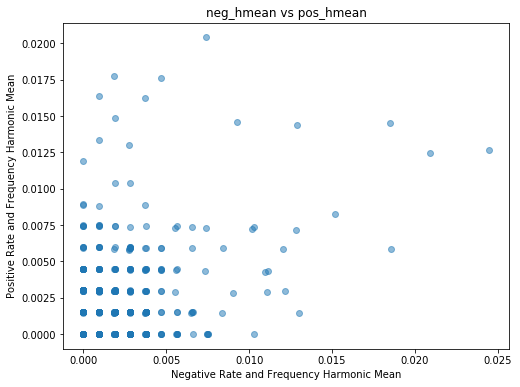

In [215]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_hmean", y="pos_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency Harmonic Mean')
plt.xlabel('Negative Rate and Frequency Harmonic Mean')
plt.title('neg_hmean vs pos_hmean')

Text(0.5, 1.0, 'neg_normcdf_hmean vs pos_normcdf_hmean')

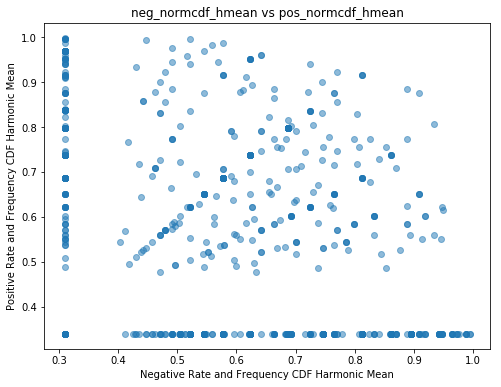

In [216]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_normcdf_hmean", y="pos_normcdf_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_normcdf_hmean vs pos_normcdf_hmean')

In [122]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
from bokeh.models import HoverTool

# Model Building

Create Training, Validation, and Test Sets

In [94]:
x = my_df.text
y = my_df.sentiment

In [95]:
from sklearn.model_selection import train_test_split
SEED = 2000

In [96]:
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size = .2, random_state=SEED)

In [97]:
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [98]:
len(x_train[y_train==0])

567

In [222]:
print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% neutral, {3:.2f}% positive".format(len(x_train), (len(x_train[y_train == -1]) / (len(x_train)*1.))*100, (len(x_train[y_train == 0]) / (len(x_train)*1.))*100, (len(x_train[y_train == 1]) / (len(x_train)*1.))*100) )

Train set has total 798 entries with 18.17% negative, 71.05% neutral, 10.78% positive


In [223]:
print("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% neutral, {3:.2f}% positive".format(len(x_validation), (len(x_validation[y_validation == -1]) / (len(x_validation)*1.))*100, (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100, (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))

Validation set has total 100 entries with 16.00% negative, 78.00% neutral, 6.00% positive


In [224]:
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% neutral, {3:.2f}% positive".format(len(x_test), (len(x_test[y_test == -1]) / (len(x_test)*1.))*100, (len(x_test[y_test == 0]) / (len(x_test)*1.))*100, (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Test set has total 100 entries with 11.00% negative, 81.00% neutral, 8.00% positive


### TextBlob

In [107]:
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [225]:
tbresult = [TextBlob(i).sentiment.polarity for i in x_validation]

In [226]:
tbpred = [-1 if n < 0 else 0 if n == 0 else 1 for n in tbresult]

In [227]:
conmat = np.array(confusion_matrix(y_validation, tbpred, labels=[-1, 0, 1]))

In [228]:
confusion = pd.DataFrame(conmat, index=['negative', 'neutral', 'positive'],
                         columns=['predicted_negative', 'predicted_neutral', 'predicted_positive'])

In [229]:
print("Accuracy Score: {0:.2f}%".format(accuracy_score(y_validation, tbpred)*100))
print("-"*80)
print("Confusion Matrix\n")
print(confusion)
print("-"*80)
print("Classification Report\n")
print(classification_report(y_validation, tbpred))

Accuracy Score: 50.00%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_neutral  predicted_positive
negative                  10                  3                   3
neutral                    9                 35                  34
positive                   1                  0                   5
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

       -1.0       0.50      0.62      0.56        16
        0.0       0.92      0.45      0.60        78
        1.0       0.12      0.83      0.21         6

avg / total       0.81      0.50      0.57       100



### Logistic Regression

In [101]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

In [102]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time

In [103]:
cvec = CountVectorizer()
lr = LogisticRegression(multi_class = 'ovr')
n_features = np.arange(100,10000,100)

In [104]:
def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

In [105]:
my_stop_words = frozenset(list(term_freq_df2.sort_values(by='total', ascending=False).iloc[:10].index))

In [108]:
print ("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_wosw = nfeature_accuracy_checker(stop_words='english')

print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug = nfeature_accuracy_checker()

print ("RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)\n")
feature_result_wocsw = nfeature_accuracy_checker(stop_words=my_stop_words)

RESULT FOR UNIGRAM WITHOUT STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 100 features
accuracy score: 77.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 200 features
accuracy score: 76.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 300 features
accuracy score: 77.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 400 features
accuracy score: 77.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 500 feat

accuracy score: 80.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 5300 features
accuracy score: 80.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 5400 features
accuracy score: 80.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 5500 features
accuracy score: 80.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 5600 features
accuracy score: 80.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 5700 features
accuracy score: 80.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 5800 feature

accuracy score: 81.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 800 features
accuracy score: 84.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 900 features
accuracy score: 83.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 1000 features
accuracy score: 83.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 1100 features
accuracy score: 83.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 1200 features
accuracy score: 82.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 1300 features


accuracy score: 82.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 6100 features
accuracy score: 82.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 6200 features
accuracy score: 82.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 6300 features
accuracy score: 82.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 6400 features
accuracy score: 82.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 6500 features
accuracy score: 82.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 6600 feature

accuracy score: 80.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 1200 features
accuracy score: 81.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 1300 features
accuracy score: 82.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 1400 features
accuracy score: 81.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 1500 features
accuracy score: 82.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 1600 features
accuracy score: 82.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 1700 feature

accuracy score: 80.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 6400 features
accuracy score: 80.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 6500 features
accuracy score: 80.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 6600 features
accuracy score: 80.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 6700 features
accuracy score: 80.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 6800 features
accuracy score: 80.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 6900 feature

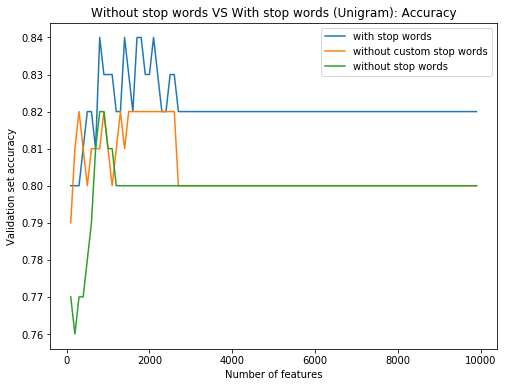

In [121]:
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wocsw = pd.DataFrame(feature_result_wocsw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wosw = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='with stop words')
plt.plot(nfeatures_plot_ug_wocsw.nfeatures, nfeatures_plot_ug_wocsw.validation_accuracy,label='without custom stop words')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [122]:
print("RESULT FOR BIGRAM WITH STOP WORDS\n")
feature_result_bg = nfeature_accuracy_checker(ngram_range=(1, 2))

print("RESULT FOR TRIGRAM WITH STOP WORDS\n")
feature_result_tg = nfeature_accuracy_checker(ngram_range=(1, 3))

RESULT FOR BIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 100 features
accuracy score: 81.00%
train and test time: 0.12s
--------------------------------------------------------------------------------
Validation result for 200 features
accuracy score: 84.00%
train and test time: 0.06s
--------------------------------------------------------------------------------
Validation result for 300 features
accuracy score: 80.00%
train and test time: 0.06s
--------------------------------------------------------------------------------
Validation result for 400 features
accuracy score: 79.00%
train and test time: 0.06s
--------------------------------------------------------------------------------
Validation result for 500 features

accuracy score: 78.00%
train and test time: 0.08s
--------------------------------------------------------------------------------
Validation result for 5000 features
accuracy score: 77.00%
train and test time: 0.08s
--------------------------------------------------------------------------------
Validation result for 5100 features
accuracy score: 78.00%
train and test time: 0.07s
--------------------------------------------------------------------------------
Validation result for 5200 features
accuracy score: 77.00%
train and test time: 0.07s
--------------------------------------------------------------------------------
Validation result for 5300 features
accuracy score: 78.00%
train and test time: 0.07s
--------------------------------------------------------------------------------
Validation result for 5400 features
accuracy score: 78.00%
train and test time: 0.07s
--------------------------------------------------------------------------------
Validation result for 5500 feature

accuracy score: 80.00%
train and test time: 0.10s
--------------------------------------------------------------------------------
Validation result for 300 features
accuracy score: 81.00%
train and test time: 0.10s
--------------------------------------------------------------------------------
Validation result for 400 features
accuracy score: 79.00%
train and test time: 0.10s
--------------------------------------------------------------------------------
Validation result for 500 features
accuracy score: 81.00%
train and test time: 0.11s
--------------------------------------------------------------------------------
Validation result for 600 features
accuracy score: 80.00%
train and test time: 0.10s
--------------------------------------------------------------------------------
Validation result for 700 features
accuracy score: 81.00%
train and test time: 0.10s
--------------------------------------------------------------------------------
Validation result for 800 features
accu

accuracy score: 76.00%
train and test time: 0.11s
--------------------------------------------------------------------------------
Validation result for 5400 features
accuracy score: 76.00%
train and test time: 0.10s
--------------------------------------------------------------------------------
Validation result for 5500 features
accuracy score: 76.00%
train and test time: 0.11s
--------------------------------------------------------------------------------
Validation result for 5600 features
accuracy score: 76.00%
train and test time: 0.11s
--------------------------------------------------------------------------------
Validation result for 5700 features
accuracy score: 76.00%
train and test time: 0.11s
--------------------------------------------------------------------------------
Validation result for 5800 features
accuracy score: 76.00%
train and test time: 0.12s
--------------------------------------------------------------------------------
Validation result for 5900 feature

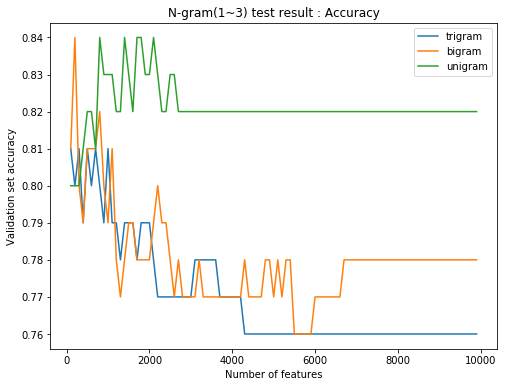

In [123]:
nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [124]:
def train_test_and_evaluate(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[-1,0,1]))
    confusion = pd.DataFrame(conmat, index=['negative', 'neutral', 'positive'],
                         columns=['predicted_negative', 'predicted_neutral', 'predicted_positive'])
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("-"*80)
    print ("Confusion Matrix\n")
    print (confusion)
    print ("-"*80)
    print ("Classification Report\n")
    print (classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))

In [125]:
%%time
tg_cvec = CountVectorizer(max_features=2500,ngram_range=(1, 1))
tg_pipeline = Pipeline([
        ('vectorizer', tg_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(tg_pipeline, x_train, y_train, x_validation, y_validation)

null accuracy: 78.00%
accuracy score: 83.00%
model is 5.00% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_neutral  predicted_positive
negative                   5                 11                   0
neutral                    3                 75                   0
positive                   0                  3                   3
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   negative       0.62      0.31      0.42        16
    neutral       0.84      0.96      0.90        78
   positive       1.00      0.50      0.67         6

avg / total       0.82      0.83      0.81       100

CPU times: user 43.8 ms, sys: 0 ns, total: 43.8 ms
Wall time: 43 ms


In [129]:
AE_test = pd.read_csv(f'AE_test.csv', low_memory=False)

In [130]:
AE_test

1241  \
0    1242   
1    1243   
2    1244   
3    1245   
4    1246   
5    1247   
6    1248   
7    1249   
8    1250   
9    1251   
10   1252   
11   1253   
12   1254   
13   1255   
14   1256   
15   1257   
16   1258   
17   1259   
18   1260   
19   1261   
20   1262   
21   1263   
22   1264   
23   1265   
24   1266   
25   1267   
26   1268   
27   1269   
28   1270   
29   1271   
..    ...   
280  1522   
281  1523   
282  1524   
283  1525   
284  1526   
285  1527   
286  1528   
287  1529   
288  1530   
289  1531   
290  1532   
291  1533   
292  1534   
293  1535   
294  1536   
295  1537   
296  1538   
297  1539   
298  1540   
299  1541   
300  1542   
301  1543   
302  1544   
303  1545   
304  1546   
305  1547   
306  1548   
307  1549   
308  1550   
309  1551   

    OTD in 2002 M7 9 earthquake struck central Alaska The quake is the 9th largest to be recorded in the US pic twitter com md33Xb3Tag  
0    1 6 magnitude earthquake 71km W of Cantwell Al...                                                                                  
1        1 7 magnitude earthquake 80km S of Tok Alaska                                                                                  
2    1 7 magnitude earthquake 62km SSW of Cantwell ...                                                                                  
3    When an earthquake strikes the locals must pic...                                                                                  
4    I m presently in SE Alaska the relatively libe...                                                                                  
5    The earthquake capitals in the U S used to be ...                                                                                  
6    5 0 earthquake 71km SE of Atka Alaska 2016 10 ...                                                                                  
7    There was an earthquake in 150km S of False Pa...                                                                                  
8    Prelim M5 8 earthquake Unimak Island region Al...                                                                                  
9    UAF Alaska Earthquake Center s initial estimat...                                                                                  
10   Earthquake in Alaska did you feel that We ll l...                                                                                  
11   Alaska was hit by 5 2 magnitude earthquake pic...                                                                                  
12   The US State of Alaska is rocked by a 5 2 magn...                                                                                  
13   Tracking and digging the 1958 M7 7 earthquake ...                                                                                  
14   Just got woken up by an earthquake In Oklahoma...                                                                                  
15   Prelim M5 5 earthquake Rat Islands Aleutian Is...                                                                                  
16   August 3 2016 15 04 33 UTC a M4 12 earthquake ...                                                                                  
17   5 3 Magnitude earthquake 13 5 miles deep 7 26 ...                                                                                  
18   Prelim M5 7 earthquake Alaska Peninsula Jul 23...                                                                                  
19   Dreamt we had an earthquake with aftershocks i...                                                                                  
20   Alaska girl forever moment the couch started s...                                                                                  
21   9 percent chance of magnitude 9 earthquake hit...                                                                                  
22   5 4 earthquake 74km SE of Nikolski Alaska 

In [135]:
AE_test = AE_test.drop(columns=['1241'])

In [139]:
AE_test = AE_test.rename(index=str, columns={"OTD in 2002 M7 9 earthquake struck central Alaska The quake is the 9th largest to be recorded in the US pic twitter com md33Xb3Tag": "text"})

In [143]:
AE_test_x = AE_test.iloc[:,:1]

In [147]:
x_pred = AE_test_x.iloc[:,0]

In [155]:
def predict(pipeline, x_train, y_train, x_predict, DataFrame):
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_predict)
    print(y_pred)
    AE_test['pred'] = y_pred
    return AE_test

In [156]:
%%time
tg_cvec = CountVectorizer(max_features=2500,ngram_range=(1, 1))
tg_pipeline = Pipeline([
        ('vectorizer', tg_cvec),
        ('classifier', lr)
    ])
predict(tg_pipeline, x_train, y_train, x_pred, AE_test)

[0. 0. 0. 0. ... 0. 0. 0. 0.]
CPU times: user 38.5 ms, sys: 0 ns, total: 38.5 ms
Wall time: 38.1 ms


In [165]:
[text for text in AE_test[AE_test.pred != 0.0].text]

['Alaska girl forever moment the couch started shaking and first thought was EARTHQUAKE when it was actually the cat scratching expat',
 'An earthquake rattled S Alaska Sunday biggest one in the region in decades pic twitter com uKxnIfEWRA',
 'sarah palin endorses trump and then a 7 1 earthquake hits alaska',
 'PHOTO Cereal boxes and juice bottles are on the floor of a grocery store following an earthquake in Alaska',
 'It s not an earthquake It s just Alaska facepalming over Sarah Palin akquake',
 'Holy moly that earthquake was terrifying Alaska One of the worst ones I ve felt Knocked me out of bed',
 'You know you live in Alaska when an earthquake wakes you up']

### TF-IDF 

In [258]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

In [259]:
feature_result_ugt = nfeature_accuracy_checker(vectorizer=tvec)
feature_result_bgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 2))
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 100 features
accuracy score: 78.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 200 features
accuracy score: 78.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 300 features
accuracy score: 77.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 400 features
accuracy score: 77.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 500 features
accuracy score: 77.00%
train and t

accuracy score: 78.00%
train and test time: 0.02s
--------------------------------------------------------------------------------
Validation result for 5400 features
accuracy score: 78.00%
train and test time: 0.02s
--------------------------------------------------------------------------------
Validation result for 5500 features
accuracy score: 78.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for 5600 features
accuracy score: 78.00%
train and test time: 0.02s
--------------------------------------------------------------------------------
Validation result for 5700 features
accuracy score: 78.00%
train and test time: 0.02s
--------------------------------------------------------------------------------
Validation result for 5800 features
accuracy score: 78.00%
train and test time: 0.02s
--------------------------------------------------------------------------------
Validation result for 5900 feature

accuracy score: 77.00%
train and test time: 0.05s
--------------------------------------------------------------------------------
Validation result for 700 features
accuracy score: 77.00%
train and test time: 0.05s
--------------------------------------------------------------------------------
Validation result for 800 features
accuracy score: 77.00%
train and test time: 0.05s
--------------------------------------------------------------------------------
Validation result for 900 features
accuracy score: 77.00%
train and test time: 0.05s
--------------------------------------------------------------------------------
Validation result for 1000 features
accuracy score: 77.00%
train and test time: 0.05s
--------------------------------------------------------------------------------
Validation result for 1100 features
accuracy score: 77.00%
train and test time: 0.06s
--------------------------------------------------------------------------------
Validation result for 1200 features
a

accuracy score: 78.00%
train and test time: 0.06s
--------------------------------------------------------------------------------
Validation result for 6000 features
accuracy score: 78.00%
train and test time: 0.06s
--------------------------------------------------------------------------------
Validation result for 6100 features
accuracy score: 78.00%
train and test time: 0.07s
--------------------------------------------------------------------------------
Validation result for 6200 features
accuracy score: 78.00%
train and test time: 0.07s
--------------------------------------------------------------------------------
Validation result for 6300 features
accuracy score: 78.00%
train and test time: 0.07s
--------------------------------------------------------------------------------
Validation result for 6400 features
accuracy score: 78.00%
train and test time: 0.07s
--------------------------------------------------------------------------------
Validation result for 6500 feature

accuracy score: 77.00%
train and test time: 0.10s
--------------------------------------------------------------------------------
Validation result for 1100 features
accuracy score: 77.00%
train and test time: 0.09s
--------------------------------------------------------------------------------
Validation result for 1200 features
accuracy score: 77.00%
train and test time: 0.08s
--------------------------------------------------------------------------------
Validation result for 1300 features
accuracy score: 77.00%
train and test time: 0.09s
--------------------------------------------------------------------------------
Validation result for 1400 features
accuracy score: 77.00%
train and test time: 0.09s
--------------------------------------------------------------------------------
Validation result for 1500 features
accuracy score: 77.00%
train and test time: 0.09s
--------------------------------------------------------------------------------
Validation result for 1600 feature

accuracy score: 78.00%
train and test time: 0.08s
--------------------------------------------------------------------------------
Validation result for 6200 features
accuracy score: 78.00%
train and test time: 0.08s
--------------------------------------------------------------------------------
Validation result for 6300 features
accuracy score: 78.00%
train and test time: 0.09s
--------------------------------------------------------------------------------
Validation result for 6400 features
accuracy score: 78.00%
train and test time: 0.10s
--------------------------------------------------------------------------------
Validation result for 6500 features
accuracy score: 78.00%
train and test time: 0.09s
--------------------------------------------------------------------------------
Validation result for 6600 features
accuracy score: 78.00%
train and test time: 0.09s
--------------------------------------------------------------------------------
Validation result for 6700 feature

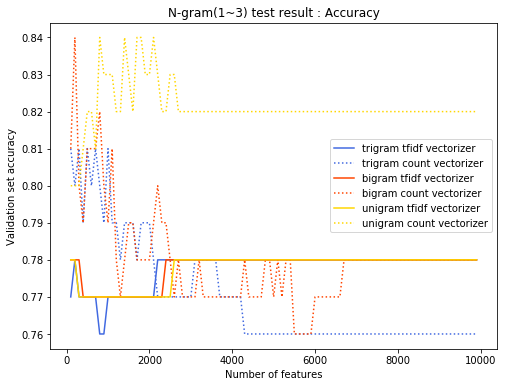

In [260]:
nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy','train_test_time'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

### Other Models

In [290]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel
from numpy.core.umath_tests import inner1d

In [291]:
names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
"Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]

In [337]:
classifiers = [
    LogisticRegression(multi_class='ovr'),
    LinearSVC(multi_class='ovr'),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf = zip(names,classifiers)

In [325]:
tvec = TfidfVectorizer()

In [338]:
def classifier_comparator(vectorizer=tvec, n_features=2500, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print("Validation result for {}".format(n))
        print(c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_accuracy,tt_time))
    return result

unigram_result = classifier_comparator(n_features=2000,ngram_range=(1,1))

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
accuracy score: 77.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
accuracy score: 86.00%
train and test time: 0.03s
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, d

/home/holden/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/holden/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [340]:
from sklearn.ensemble import VotingClassifier

clf1 = BernoulliNB()
clf2 = LinearSVC()
clf3 = Perceptron()
clf4 = RidgeClassifier()
clf5 = PassiveAggressiveClassifier()

eclf = VotingClassifier(estimators=[('bern', clf1), ('svc', clf2), ('perc', clf3), ('rcs', clf4), ('pac', clf5)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], ['Bernoulli NB', 'Linear SVC', 'Perceptron', 'Ridge Classifier', 'Passive Aggresive Classifier', 'Ensemble']):
    checker_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(max_features=2000,ngram_range=(1, 1))),
            ('classifier', clf)
        ])
    print("Validation result for {}".format(label))
    print(clf)
clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)

Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Validation result for Perceptron
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      max_iter=None, n_iter=None, n_jobs=1, penalty=None, random_state=0,
      shuffle=True, tol=None, verbose=0, warm_start=False)
Validation result for Ridge Classifier
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)
Validation result for Passive Aggresive Classifier
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=None,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=Fa

/home/holden/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/holden/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/holden/an

In [341]:
clf1 = LinearSVC()
clf2 = RidgeClassifier()
clf3 = PassiveAggressiveClassifier()

eclf = VotingClassifier(estimators=[('svc', clf1), ('rcs', clf2), ('pac', clf3)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Linear SVC', 'Ridge Classifier', 'Passive Aggresive Classifier', 'Ensemble']):
    checker_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(max_features=2000,ngram_range=(1, 1))),
            ('classifier', clf)
        ])
    print("Validation result for {}".format(label))
    print(clf)
clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)

Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Validation result for Ridge Classifier
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)
Validation result for Passive Aggresive Classifier
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=None,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False)
Validation result for Ensemble
VotingClassifier(estimators=[('svc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2',

/home/holden/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/holden/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Kaggle Approach

In [38]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [46]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(my_df.sentiment)

In [47]:
xtrain, xvalid, ytrain, yvalid = train_test_split(my_df.text, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

#### TF-IDF + Logistic Regression

In [49]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

In [50]:
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

In [51]:
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.652 


#### CountVectorizer

In [52]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

In [53]:
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

In [54]:
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.716 


#### Naive Bayes

In [55]:
clf = MultinomialNB()
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.623 


In [56]:
clf = MultinomialNB()
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 2.720 


#### SVM

In [57]:
svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)

In [58]:
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)

In [59]:
clf = SVC(C=1.0, probability=True) # since we need probabilities
clf.fit(xtrain_svd_scl, ytrain)
predictions = clf.predict_proba(xvalid_svd_scl)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.706 


#### XGBoost

In [62]:
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_tfv.tocsc(), ytrain)
predictions = clf.predict_proba(xvalid_tfv.tocsc())

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.739 


In [63]:
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_ctv.tocsc(), ytrain)
predictions = clf.predict_proba(xvalid_ctv.tocsc())

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.661 


In [64]:
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_svd, ytrain)
predictions = clf.predict_proba(xvalid_svd)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.929 


In [65]:
clf = xgb.XGBClassifier(nthread=10)
clf.fit(xtrain_svd, ytrain)
predictions = clf.predict_proba(xvalid_svd)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.656 


##### Grid Search

In [66]:
mll_scorer = metrics.make_scorer(multiclass_logloss, greater_is_better=False, needs_proba=True)

In [67]:
svd = TruncatedSVD()
scl = preprocessing.StandardScaler()
lr_model = LogisticRegression()
clf = pipeline.Pipeline([('svd', svd),
                         ('scl', scl),
                         ('lr', lr_model)])

In [68]:
param_grid = {'svd__n_components' : [120, 180],
              'lr__C': [0.1, 1.0, 10], 
              'lr__penalty': ['l1', 'l2']}

In [69]:
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=mll_scorer,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)

In [70]:
model.fit(xtrain_tfv, ytrain)
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV] lr__C=0.1, lr__penalty=l1, svd__n_components=120 ................
[CV] lr__C=0.1, lr__penalty=l1, svd__n_components=120 ................
[CV] lr__C=0.1, lr__penalty=l1, svd__n_components=180 ................
[CV] lr__C=0.1, lr__penalty=l1, svd__n_components=180 ................
[CV] lr__C=0.1, lr__penalty=l2, svd__n_components=120 ................
[CV] lr__C=0.1, lr__penalty=l2, svd__n_components=180 ................
[CV] lr__C=0.1, lr__penalty=l2, svd__n_components=180 ................
[CV] lr__C=0.1, lr__penalty=l2, svd__n_components=120 ................
[CV]  lr__C=0.1, lr__penalty=l1, svd__n_components=120, score=-0.7074187322536457, total=   0.7s
[CV]  lr__C=0.1, lr__penalty=l2, svd__n_components=120, score=-0.6662539818306834, total=   0.7s
[CV] lr__C=1.0, lr__penalty=l1, svd__n_components=120 ................
[CV] lr__C=1.0, lr__penalty=l1, svd__n_components=120 ................


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


[CV]  lr__C=0.1, lr__penalty=l1, svd__n_components=180, score=-0.7050150550929084, total=   1.0s
[CV]  lr__C=0.1, lr__penalty=l2, svd__n_components=180, score=-0.6719548309642898, total=   1.0s
[CV] lr__C=1.0, lr__penalty=l1, svd__n_components=180 ................
[CV] lr__C=1.0, lr__penalty=l1, svd__n_components=180 ................
[CV]  lr__C=0.1, lr__penalty=l2, svd__n_components=180, score=-0.6863441548946371, total=   1.2s
[CV] lr__C=1.0, lr__penalty=l2, svd__n_components=120 ................
[CV]  lr__C=1.0, lr__penalty=l1, svd__n_components=120, score=-0.768032593185976, total=   0.6s
[CV] lr__C=1.0, lr__penalty=l2, svd__n_components=120 ................
[CV]  lr__C=1.0, lr__penalty=l2, svd__n_components=120, score=-0.8205809402057308, total=   0.5s
[CV] lr__C=1.0, lr__penalty=l2, svd__n_components=180 ................
[CV]  lr__C=1.0, lr__penalty=l2, svd__n_components=120, score=-0.7971721562560992, total=   0.7s
[CV] lr__C=1.0, lr__penalty=l2, svd__n_components=180 ..........

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.8s


[CV]  lr__C=1.0, lr__penalty=l2, svd__n_components=180, score=-0.9825925340110575, total=   1.1s
[CV] lr__C=10, lr__penalty=l1, svd__n_components=180 .................


[Parallel(n_jobs=-1)]: Done  12 out of  24 | elapsed:    3.1s remaining:    3.1s


[CV]  lr__C=1.0, lr__penalty=l2, svd__n_components=180, score=-1.0106210270631923, total=   1.6s
[CV] lr__C=10, lr__penalty=l2, svd__n_components=120 .................
[CV]  lr__C=10, lr__penalty=l2, svd__n_components=120, score=-1.504750784747095, total=   0.4s
[CV] lr__C=10, lr__penalty=l2, svd__n_components=120 .................
[CV]  lr__C=0.1, lr__penalty=l1, svd__n_components=120, score=-0.7123482056033004, total=   4.2s
[CV] lr__C=10, lr__penalty=l2, svd__n_components=180 .................


[Parallel(n_jobs=-1)]: Done  15 out of  24 | elapsed:    4.3s remaining:    2.6s


[CV]  lr__C=10, lr__penalty=l2, svd__n_components=120, score=-1.5678026311247983, total=   0.5s
[CV]  lr__C=10, lr__penalty=l1, svd__n_components=120, score=-1.6491088005245795, total=   1.8s
[CV] lr__C=10, lr__penalty=l2, svd__n_components=180 .................
[CV]  lr__C=1.0, lr__penalty=l1, svd__n_components=120, score=-0.7769072345070105, total=   3.9s
[CV]  lr__C=0.1, lr__penalty=l2, svd__n_components=120, score=-0.6772406671245677, total=   4.7s


[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed:    4.6s remaining:    1.5s


[CV]  lr__C=10, lr__penalty=l1, svd__n_components=180, score=-2.5346493819222324, total=   2.3s
[CV]  lr__C=10, lr__penalty=l2, svd__n_components=180, score=-1.881183489040627, total=   0.6s
[CV]  lr__C=10, lr__penalty=l2, svd__n_components=180, score=-2.0132650998537214, total=   1.0s


[Parallel(n_jobs=-1)]: Done  21 out of  24 | elapsed:    5.3s remaining:    0.8s


[CV]  lr__C=10, lr__penalty=l1, svd__n_components=120, score=-1.932884505179278, total=   2.9s
[CV]  lr__C=10, lr__penalty=l1, svd__n_components=180, score=-2.947524241429578, total=   2.9s
Best score: -0.672
Best parameters set:
	lr__C: 0.1
	lr__penalty: 'l2'
	svd__n_components: 120


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    5.9s finished


In [71]:
nb_model = MultinomialNB()

# Create the pipeline 
clf = pipeline.Pipeline([('nb', nb_model)])

# parameter grid
param_grid = {'nb__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=mll_scorer,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)

# Fit Grid Search Model
model.fit(xtrain_tfv, ytrain)  # we can use the full data here but im only using xtrain. 
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] nb__alpha=0.001 .................................................
[CV] nb__alpha=0.001 .................................................
[CV] nb__alpha=0.01 ..................................................
[CV] nb__alpha=0.01 ..................................................
[CV] ....... nb__alpha=0.001, score=-1.3249640432024474, total=   0.0s
[CV] nb__alpha=0.1 ...................................................
[CV] ....... nb__alpha=0.001, score=-1.3764315955766724, total=   0.0s
[CV] nb__alpha=1 .....................................................
[CV] ........ nb__alpha=0.01, score=-0.9067525781183594, total=   0.0s
[CV] nb__alpha=0.1 ...................................................
[CV] nb__alpha=1 .....................................................
[CV] nb__alpha=10 ....................................................
[CV] ......... nb__alpha=0.1, score=-0.6744821734314123, total=   0.0s
[CV] ........... 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0216s.) Setting batch_size=18.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished


#### Word Vectors